In [ ]:
# 得到点集合

In [ ]:
import numpy as np
import os
import cv2
import math
import matplotlib.pyplot as plt
from shapely import wkt, geometry
from shapely.geometry import Polygon
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from scipy.ndimage.measurements import label
from scipy.ndimage.morphology import generate_binary_structure
from skimage import morphology
from skimage import io
from tqdm import tqdm
import pickle

In [ ]:
class Point():
    """
    点类
    """
    x = 0.0
    y = 0.0
    index = 0  # 点在线上的索引

    def __init__(self, x, y, index):
        self.x = x
        self.y = y
        self.index = index


class Douglas():
    """ 道格拉斯算法 """

    def __init__(self, distThre=4):
        """
        distThre: 这个是像素之间的容差
        """
        self.points = []
        self.D = distThre  # 容差, 坐标之间的距离（坐标是像素中心点，因此此处可以看作是像素个数之间的距离）
        self.pointsout = []

    def readPoint(self, contour):
        """生成点要素"""
        for i in range(len(contour)):
            self.points.append(Point(x=contour[i, 0], y=contour[i, 1], index=i))  # 取每个坐标的(x, y), 并加上索引
        self.pointsout = self.points

    def compress(self, p1, p2):
        """
        具体的抽稀算法
        p1 = (Xp1, Yp1) -> (p1.x, p1.y)
        p2 = (Xp2, Yp2) -> (p2.x, p2.y)
        """
        swichvalue = False
        # 一般式直线方程系数 A*x+B*y+C=0, 利用两点求解方程系数
        A = (p1.y - p2.y)
        B = (p2.x - p1.x)
        C = (p1.x * p2.y - p2.x * p1.y)

        m = self.points.index(p1)  # 列表第一个点
        n = self.points.index(p2)  # 列表最后一个点
        distance = []
        middle = None
        if n == m + 1:  # 也就是只有两个点
            return

        # 计算中间点与直线的距离
        for i in range(m + 1, n):
            d = abs(A * self.points[i].x + B * self.points[i].y + C) / math.sqrt(math.pow(A, 2) + math.pow(B, 2))  # 点到直线的距离
            distance.append(d)
        dmax = max(distance)
        if dmax > self.D:
            swichvalue = True
        else:
            swichvalue = False

        if not swichvalue:
            t = 0
            for i in range(m + 1, n):
                del self.points[i - t]
                t = t + 1
        else:
            for i in range(m + 1, n):
                if distance[i - m - 1] == dmax:  # abs(A*self.points[i].x+B*self.points[i].y+C)/math.sqrt(math.pow(A,2)+math.pow(B,2))
                    middle = self.points[i]
                    break
            self.compress(p1, middle)
            self.compress(middle, p2)


def DouglasPeuker(contours, Thre):  # 道格拉斯抽稀
    """
    contours: [轮廓个数, 点个数, 1 , XY]
    Thre: 抽稀的容差
    """
    sparsePoints = []
    d = Douglas(distThre=Thre)
    for _, contour in enumerate(contours):
        d.points = []
        contour = np.squeeze(contour)
        # contour = shapelysimplify(contour)
        d.readPoint(contour)  # [[x, y, index], ...]
        d.compress(d.points[0], d.points[len(d.points) - 1])  # 当前点（x, y, index）和上一个点（x, y, index）
        pointssize = len(d.points)
        plist = np.zeros((pointssize, 2), dtype=np.int32)
        for i in range(pointssize):
            plist[i, 0] = d.points[i].x
            plist[i, 1] = d.points[i].y
        sparsePoints.append(plist)
    return sparsePoints

def getTiff(imgPath):
    ds = gdal.Open(imgPath)
    GeoTrans = ds.GetGeoTransform()  # 仿射矩阵
    ref_width = ds.RasterXSize  # 栅格矩阵的列数
    ref_height = ds.RasterYSize  # 栅格矩阵的行数
    ref_Proj = ds.GetProjection()  # 投影信息
    imgArr = ds.ReadAsArray(0, 0, ref_width, ref_height)  # 将数据写成数组，对应栅格矩阵
    print(np.unique(imgArr))
    return ds, GeoTrans, ref_width, ref_height, ref_Proj, imgArr

def arr2tiff(ref, save_path, arr):
    # plt.imsave(save_path, arr)  # 保存为jpg格式
    _, GeoTrans, ref_width, ref_height, ref_Proj, _ = getTiff(ref)
    # 保存为TIF格式
    driver = gdal.GetDriverByName("GTiff")
    assert (ref_width, ref_height) == (arr.shape[1], arr.shape[2]), print('栅格尺寸与参考影像不匹配!')
    datasetnew = driver.Create(save_path, ref_width, ref_height, 1, gdal.GDT_CInt16)
    datasetnew.SetGeoTransform(GeoTrans)
    datasetnew.SetProjection(ref_Proj)
    band = datasetnew.GetRasterBand(1)
    band.WriteArray(arr)
    datasetnew.FlushCache()  # Write to disk.必须清除缓存
    print('finished!')

def toshp(ds, GeoTrans, contours, strVectorFile):
    """
    点坐标写入矢量文件
    ds :
    Geoimg :
    contours :
    strVectorFile :
    """
    gdal.SetConfigOption("GDAL_FILENAME_IS_UTF8", "NO")  # 为了支持中文路径
    gdal.SetConfigOption("SHAPE_ENCODING", "")  # CP936, 为了使属性表字段支持中文

    ogr.RegisterAll()  # 注册所有的驱动
    strDriverName = "ESRI Shapefile"  # 创建数据，这里以创建ESRI的shp文件为例
    oDriver = ogr.GetDriverByName(strDriverName)
    if oDriver is None:
        print("驱动不可用！")
    oDS = oDriver.CreateDataSource(strVectorFile)  # 创建数据源
    if oDS is None:
        print("创建文件失败！")

    srs = osr.SpatialReference()
    srs.ImportFromWkt(ds.GetProjectionRef())
    papszLCO = []
    oLayer = oDS.CreateLayer("Polygon", srs, ogr.wkbPolygon, papszLCO)
    if oLayer is None:
        print("图层创建失败！")
    # 创建一个叫FieldID的整型属性
    oFieldID = ogr.FieldDefn("FieldID", ogr.OFTInteger)
    oLayer.CreateField(oFieldID, 1)
    oDefn = oLayer.GetLayerDefn()

    # 生成多个多边形要素
    i = 0
    for contour in tqdm(contours):

        box1 = ogr.Geometry(ogr.wkbLinearRing)
        i += 1
        for point in contour:
            # 将像素坐标转地理坐标
            x_col = GeoTrans[0] + GeoTrans[1] * (float(point[0])) + (float(point[1])) * GeoTrans[2]
            y_row = GeoTrans[3] + GeoTrans[4] * (float(point[0])) + (float(point[1])) * GeoTrans[5]
            box1.AddPoint(x_col, y_row)
        oFeatureTriangle = ogr.Feature(oDefn)
        oFeatureTriangle.SetField(0, i)
        garden1 = ogr.Geometry(ogr.wkbPolygon)
        garden1.AddGeometry(box1)
        garden1.CloseRings()
        geomTriangle = ogr.CreateGeometryFromWkt(str(garden1))
        oFeatureTriangle.SetGeometry(geomTriangle)
        oLayer.CreateFeature(oFeatureTriangle)
    oDS.Destroy()
    xpixel = GeoTrans[1]
    ypixel = GeoTrans[5]
    return xpixel, ypixel



In [ ]:
def morph(img, value, areaThreshold, connectivity, kernel, areathreshold=0):
    """
    img: 输入的原始影像
    value: 指定处理的类别
    areaThreshold: 去除的面积阈值
    connectivity: 连通区域设定
    kernel: 形态学运算的核大小
    """
    # 1. 去除面积小于指定值的区域
    contours = []
    img = img == value
    img = morphology.remove_small_objects(img, min_size=areaThreshold, connectivity=connectivity)
    img = np.array(img * 1, dtype=np.uint8)

    # 2. 形态学运算，去除小点
    # kernel = np.ones(kernel, np.uint8)
    # img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2)  # Open to erode small patches  开运算腐蚀小点
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, (5, 5), iterations=2)  # Close little holes  闭运算去除空洞
    # img = img.astype('uint8')

    # 3. 计算斑块数量
    if connectivity == 1:
        numPatch = generate_binary_structure(2, 1)  # 四连通
    if connectivity == 2:
        numPatch = generate_binary_structure(2, 2)  # 八连通

    # 4. 计算轮廓,以像素坐标点表示
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # < contours：返回的轮廓像素坐标点; hierarchy：每条轮廓对应的属性 >

    # 保存list pkl
    with open('/mnt/share/Garfield/parcel_15cm/post_processing/processingEdge/seg_postprocess/contours.pkl', 'wb') as f:
        pickle.dump(contours, f)
    
    # 5. 再次去除小区域
    # 可改进：此处去除小面积可以先统计然后根据统计值设置阈值去除
    contoursNew = []
    for i in range(len(contours)):
        contour = contours[i]
        area = cv2.contourArea(contour)
        print(area)
        if area > areathreshold:  # 面积大于n才保存
            contoursNew.append(contour)

    return contours

def cal_convexHull(points_input):
    """
    计算凸包
    Args:
        points_input: shape=list[point_nums, 2]
    Returns: shape=list[point_nums, 2]
    """
    # 计算凸包
    res = []
    for i in range(len(points_input)):
        hull = cv2.convexHull(points_input[i].reshape(-1, 1, 2))
        res.append(hull[:, 0, :])  # [points_num, x_y]
    return res

def cal_defectpoints(points_input):
    """
    计算凸包角点的索引
    Args:
        points_input: shape=list[point_nums, 2]
    Returns: shape=list[point_nums, 2]
    """

    res = []
    for i in range(len(points_input)):
        tmp = []
        hull = cv2.convexHull(points_input[i].reshape(-1, 1, 2), returnPoints=False)
        for point in hull:
            tmp.append(points_input[i][point].tolist()[0])
        res.append(np.array(tmp))
    return res


def select_diff_dp_convex(points1, points2, thre=9 / 10):
    """
    Args:
        points1: 凸包点 list[point_nums, 2]
        points2: 原始值 list[point_nums, 2]
        thre: 原始面积/凸包面积: 凸包面积一定>=原始面积 9/10为面积差不超10%
    Returns:

    """
    # 根据凸包与原点集的面积比进行筛选
    contours_convex = points1  # 凸包点
    contours_dp = points2  # 原始值
    contours_convex_selected_1 = []  # 满足要求的凸包
    contours_convex_selected_2 = []  # 不满足要求的凸包
    for i in range(len(contours_convex)):
        contour_dp_area = cv2.contourArea(contours_dp[i])
        contour_convex_area = cv2.contourArea(contours_convex[i])
        if contour_dp_area / contour_convex_area < thre:
            contours_convex_selected_2.append((i, contours_convex[i]))
            continue
        contours_convex_selected_1.append((i, contours_convex[i]))
    return contours_convex_selected_1, contours_convex_selected_2

def raster2shp(image_path, strVectorFile, kernel, areaThreshold=32):
    """
    image_path: 待矢量化的影像
    strVectorFile: 矢量化文件保存路径
    kernel: 形态学运算的核大小
    value: 指定处理的类别
    areaThreshold: 去除的面积阈值
    """
    # 1. 获取影像的数据、投影属性
    ds, GeoTrans, _, _, _, imgArr = getTiff(image_path)
    # 2. 形态学处理，返回以像素坐标点表示的轮廓 [[[[p1, p2]], [[p1, p2]]], ...]
    contours_morph = morph(imgArr, value=1, areaThreshold=areaThreshold, connectivity=1, kernel=kernel, areathreshold=200)  # 目标像素值,去除小区域面积阈值,连通性(1->4; 2->8)
    # # 3. 道格拉斯算法简化:后处理的原始值
    # # contours_dp = [points_num, x, y] = [np.array[[x1, y1], ...], np.array([[x1, y1], ...])]
    # contours_dp = DouglasPeuker(contours_morph, Thre=2)

    # # 使用凸包检测将点分成两类
    # contours_convex = cal_convexHull(contours_dp)
    # # 将点集分为两部分 1是满足面积的，2是不满足
    # contours_convex_selected_1, contours_convex_selected_2 = select_diff_dp_convex(contours_convex, contours_dp)

    # # . 矢量化处理得到的点
    # _, _ = toshp(ds, GeoTrans, contours_dp, strVectorFile)
    return

if __name__ == "__main__":
    # 单图矢量化
    # /mnt/share/Garfield/parcel_15cm/post_processing/processingEdge/seg_postprocess
    # merge_test_resample_15cm_Predict_slidingwindow_256_seg_skeleton_shp_EliminatePolygo2R:边界+分割

    imgpath = "/mnt/share/Garfield/parcel_15cm/post_processing/processingEdge/merge_test_resample_15cm_Predict_slidingwindow_256_seg_skeleton_shp_EliminatePolygo2R.tif"

    raster2shp(imgpath, "/mnt/share/Garfield/parcel_15cm/post_processing/processingEdge/merge_test_resample_15cm_Predict_slidingwindow_256_seg_skeleton_shp_EliminatePolygo2R_k_7_7.shp", kernel=(7, 7), areaThreshold=100)

    print('finished !')


In [ ]:
# 规则化点集

In [21]:
# 读取pickle
import numpy as np
import os
import cv2
import math
import matplotlib.pyplot as plt
from shapely import wkt, geometry
from shapely.geometry import Polygon
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from scipy.ndimage.measurements import label
from scipy.ndimage.morphology import generate_binary_structure
from skimage import morphology
from skimage import io
from tqdm import tqdm
import pickle
import time

with open('/mnt/share/Garfield/parcel_15cm/post_processing/processingEdge/seg_postprocess/contours.pkl', 'rb') as f:
    contours = pickle.load(f)

print(len(contours))
print(contours[0].shape)
print(contours[0][:, 0, :].shape)

def polygon_area(vertices):
    """
    # 假设你有一些点的坐标
    # 注意：坐标点的顺序要组成一个封闭的多边形
    vertices = [(x1, y1), 
                (x2, y2),
                (x3, y3),
                # 添加更多的点
                ]

    # 计算多边形的面积
    area = polygon_area(vertices)

    print(f"多边形的面积为: {area}")

    """
    n = len(vertices)
    area = 0

    for i in range(n):
        j = (i + 1) % n
        area += vertices[i][0] * vertices[j][1]
        area -= vertices[j][0] * vertices[i][1]

    area = abs(area) / 2.0
    return area

def recovery_pts(pts, x_min, y_min):
    pts[:, 0] = pts[:, 0] + x_min
    pts[:, 1] = pts[:, 1] + y_min

    return pts

def toshp(ds, GeoTrans, contours, strVectorFile):
    """
    点坐标写入矢量文件
    ds :
    Geoimg :
    contours :
    strVectorFile :
    """
    gdal.SetConfigOption("GDAL_FILENAME_IS_UTF8", "NO")  # 为了支持中文路径
    gdal.SetConfigOption("SHAPE_ENCODING", "")  # CP936, 为了使属性表字段支持中文

    ogr.RegisterAll()  # 注册所有的驱动
    strDriverName = "ESRI Shapefile"  # 创建数据，这里以创建ESRI的shp文件为例
    oDriver = ogr.GetDriverByName(strDriverName)
    if oDriver is None:
        print("驱动不可用！")
    oDS = oDriver.CreateDataSource(strVectorFile)  # 创建数据源
    if oDS is None:
        print("创建文件失败！")

    srs = osr.SpatialReference()
    srs.ImportFromWkt(ds.GetProjectionRef())
    papszLCO = []
    oLayer = oDS.CreateLayer("Polygon", srs, ogr.wkbPolygon, papszLCO)
    if oLayer is None:
        print("图层创建失败！")
    # 创建一个叫FieldID的整型属性
    oFieldID = ogr.FieldDefn("FieldID", ogr.OFTInteger)
    oLayer.CreateField(oFieldID, 1)
    oDefn = oLayer.GetLayerDefn()

    # 生成多个多边形要素
    i = 0
    for contour in tqdm(contours):

        box1 = ogr.Geometry(ogr.wkbLinearRing)
        i += 1
        for point in contour:
            # 将像素坐标转地理坐标
            x_col = GeoTrans[0] + GeoTrans[1] * (float(point[0])) + (float(point[1])) * GeoTrans[2]
            y_row = GeoTrans[3] + GeoTrans[4] * (float(point[0])) + (float(point[1])) * GeoTrans[5]
            box1.AddPoint(x_col, y_row)
        oFeatureTriangle = ogr.Feature(oDefn)
        oFeatureTriangle.SetField(0, i)
        garden1 = ogr.Geometry(ogr.wkbPolygon)
        garden1.AddGeometry(box1)
        garden1.CloseRings()
        geomTriangle = ogr.CreateGeometryFromWkt(str(garden1))
        oFeatureTriangle.SetGeometry(geomTriangle)
        oLayer.CreateFeature(oFeatureTriangle)
    oDS.Destroy()
    xpixel = GeoTrans[1]
    ypixel = GeoTrans[5]
    return xpixel, ypixel

def getTiff(imgPath):
    ds = gdal.Open(imgPath)
    GeoTrans = ds.GetGeoTransform()  # 仿射矩阵
    ref_width = ds.RasterXSize  # 栅格矩阵的列数
    ref_height = ds.RasterYSize  # 栅格矩阵的行数
    ref_Proj = ds.GetProjection()  # 投影信息
    imgArr = ds.ReadAsArray(0, 0, ref_width, ref_height)  # 将数据写成数组，对应栅格矩阵
    print(np.unique(imgArr))
    return ds, GeoTrans, ref_width, ref_height, ref_Proj, imgArr

from collections import deque

def getEndPoint(imgArr):
    """
    如果一个点是端点，那么要么
    args:
        imgArr : 二值化后的图像
    return:
        endPoints : 端点坐标、相应的结点
    """
    imgArr[imgArr != 0] = 1
    w, h = imgArr.shape
    endPoints = []
    for i in range(w):
        for j in range(h):
                # 零值不考虑
                if imgArr[i, j] == 0:
                    continue
                # 判断八邻域的连接情况，如果只有一个连接，那么就是端点
                # connectivity = top + below + left + right + left_top + right_top + left_below + right_below
                connectivity = int(imgArr[i-1, j]) + int(imgArr[i+1, j]) + int(imgArr[i, j-1]) + int(imgArr[i, j+1]) + int(imgArr[i-1, j-1]) + int(imgArr[i-1, j+1]) + int(imgArr[i+1, j-1]) + int(imgArr[i+1, j+1])
                if connectivity == 1:
                    # 判断是否是伪端点，通过二阶8邻域判断（未完成）
                    endPoints.append([i, j])
    return endPoints

def getBranch(imgArr, endPoint):
    """
    通过端点获取分支, 通过广度优先搜索
    args:
        imgArr : 二值化后的图像
        endPoint : 端点坐标
    """
    print("endPoint:", endPoint.shape)
    endPoint = endPoint.tolist()
    # 遍历每个端点
    if not endPoint:
        return []
    branchs = []
    for point in endPoint:  # point = [i, j]
        # 通过广度优先搜索获取分支
        branch = []
        queue = deque()
        queue.append(point)  # 队列初始化

        while queue:
            point = queue.popleft()  # 获取队列首元素

            if point in branch:  # 判断是否已经遍历过
                continue

            branch.append(point)  # 出队的点添加到分支（保证点为有效点）

            # 获取八邻域
            neighbors = [[point[0]-1, point[1]], [point[0]+1, point[1]], [point[0], point[1]-1], [point[0], point[1]+1], 
                         [point[0]-1, point[1]-1], [point[0]-1, point[1]+1], [point[0]+1, point[1]-1], [point[0]+1, point[1]+1]]
            
            connect = 0  # 判断该点是几邻域联通
            for neighbor in neighbors:
                connect += imgArr[neighbor[0], neighbor[1]]
            if connect > 2:
                break  # 如果大于1，说明该点是交叉点，跳出while循环

            for neighbor in neighbors:
                if imgArr[neighbor[0], neighbor[1]] == 0:
                    continue

                else:
                    queue.append(neighbor)
        branchs.append((branch))
    return branchs

def removeBranch(img_bin, branch):
    """
    移除分支, 分支适当扩张
    args:
        img_bin : 二值化后的图像
        branch : 分支
    """
    # 分支扩张
    for point in branch:
        # 获取八邻域
        neighbors = [[point[0]-1, point[1]], [point[0]+1, point[1]], [point[0], point[1]-1], [point[0], point[1]+1], 
                     [point[0]-1, point[1]-1], [point[0]-1, point[1]+1], [point[0]+1, point[1]-1], [point[0]+1, point[1]+1]]
        for neighbor in neighbors:
            img_bin[neighbor[0], neighbor[1]] = 1
    return img_bin

5588
(19, 1, 2)
(19, 2)


点形状： (505, 2)
面积： 514.56375
原始的x_min, y_min 23452 29508
归一化后的x_min, y_min 50 50
endPoint: (1, 2)
交点个数： 1
端点个数： 1


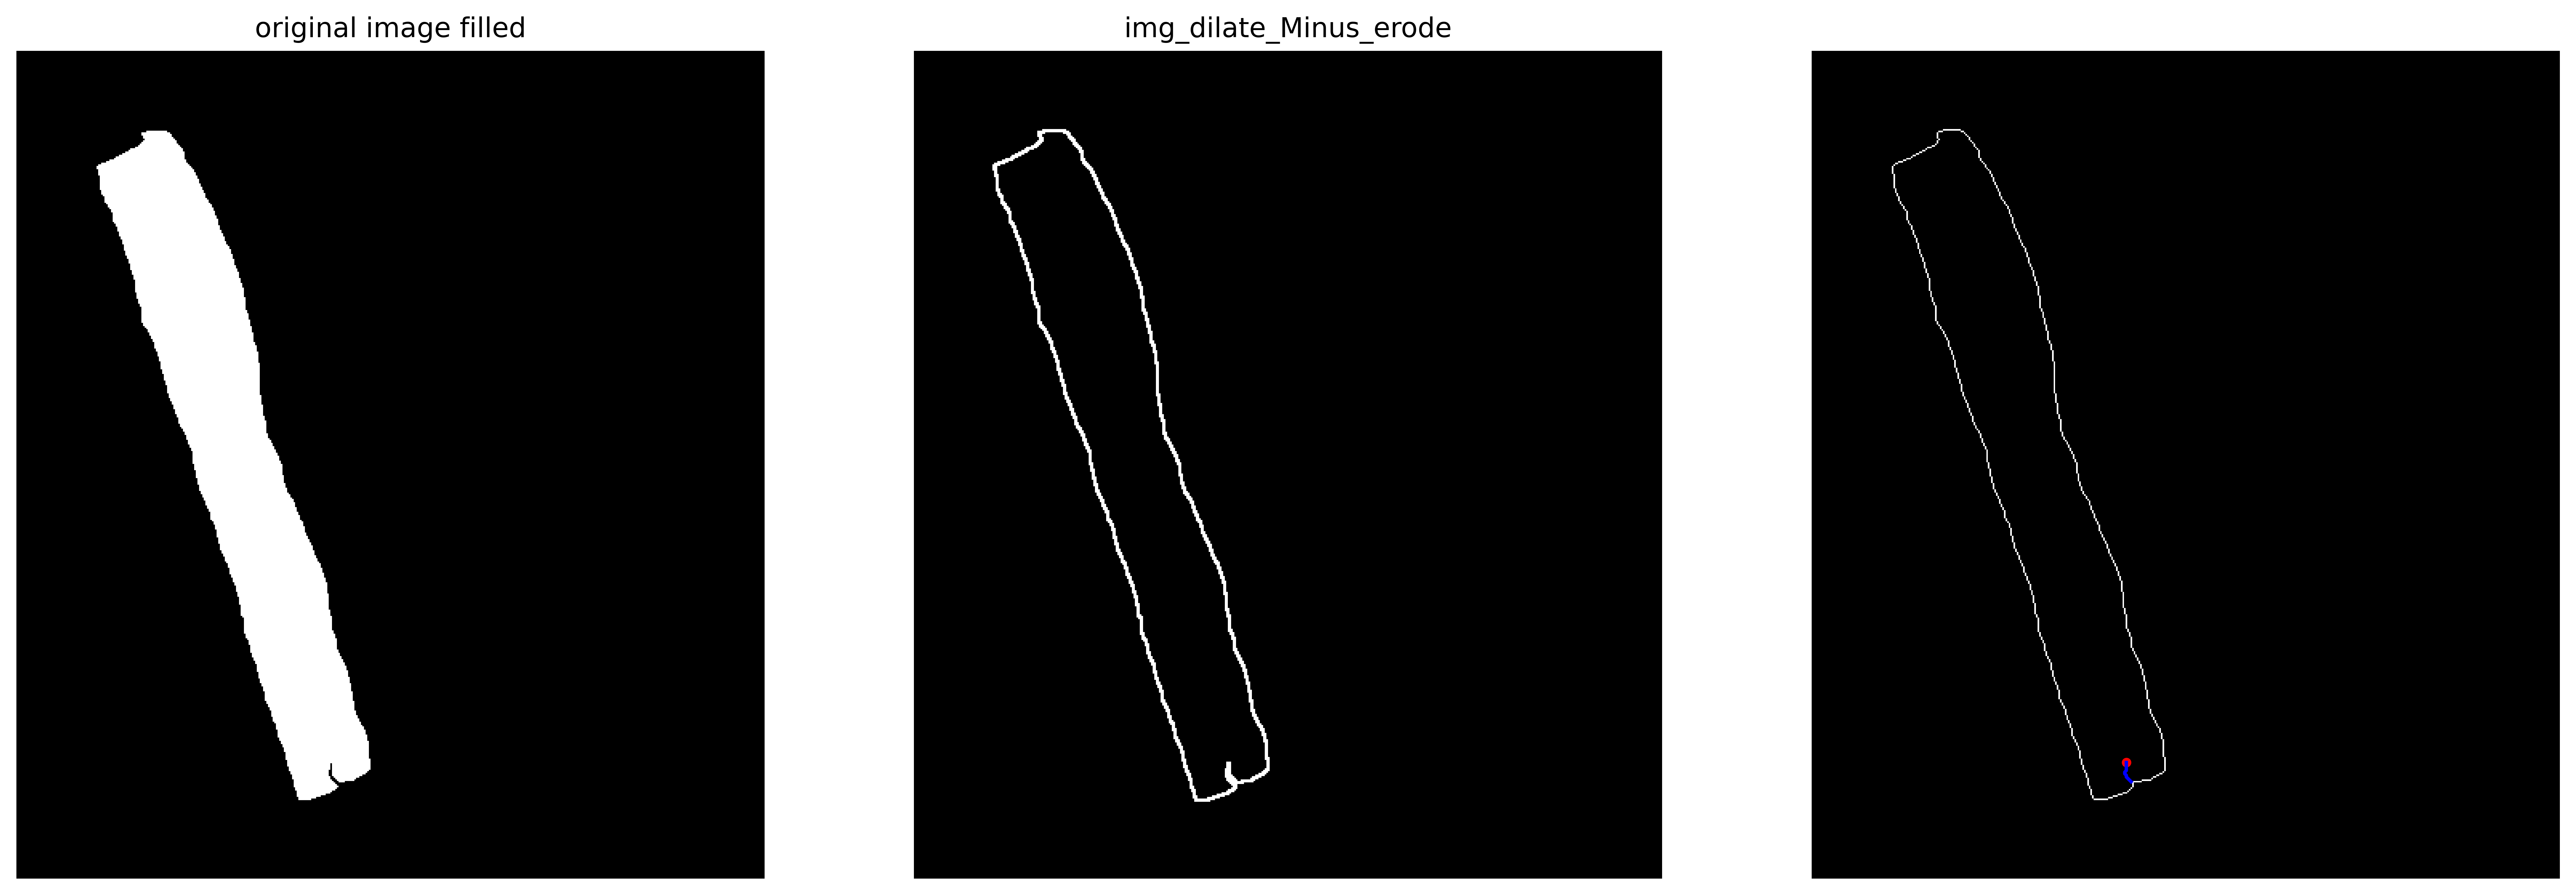

点形状： (85, 2)
面积： 116.56125
原始的x_min, y_min 9573 29505
归一化后的x_min, y_min 50 50
endPoint: (0,)


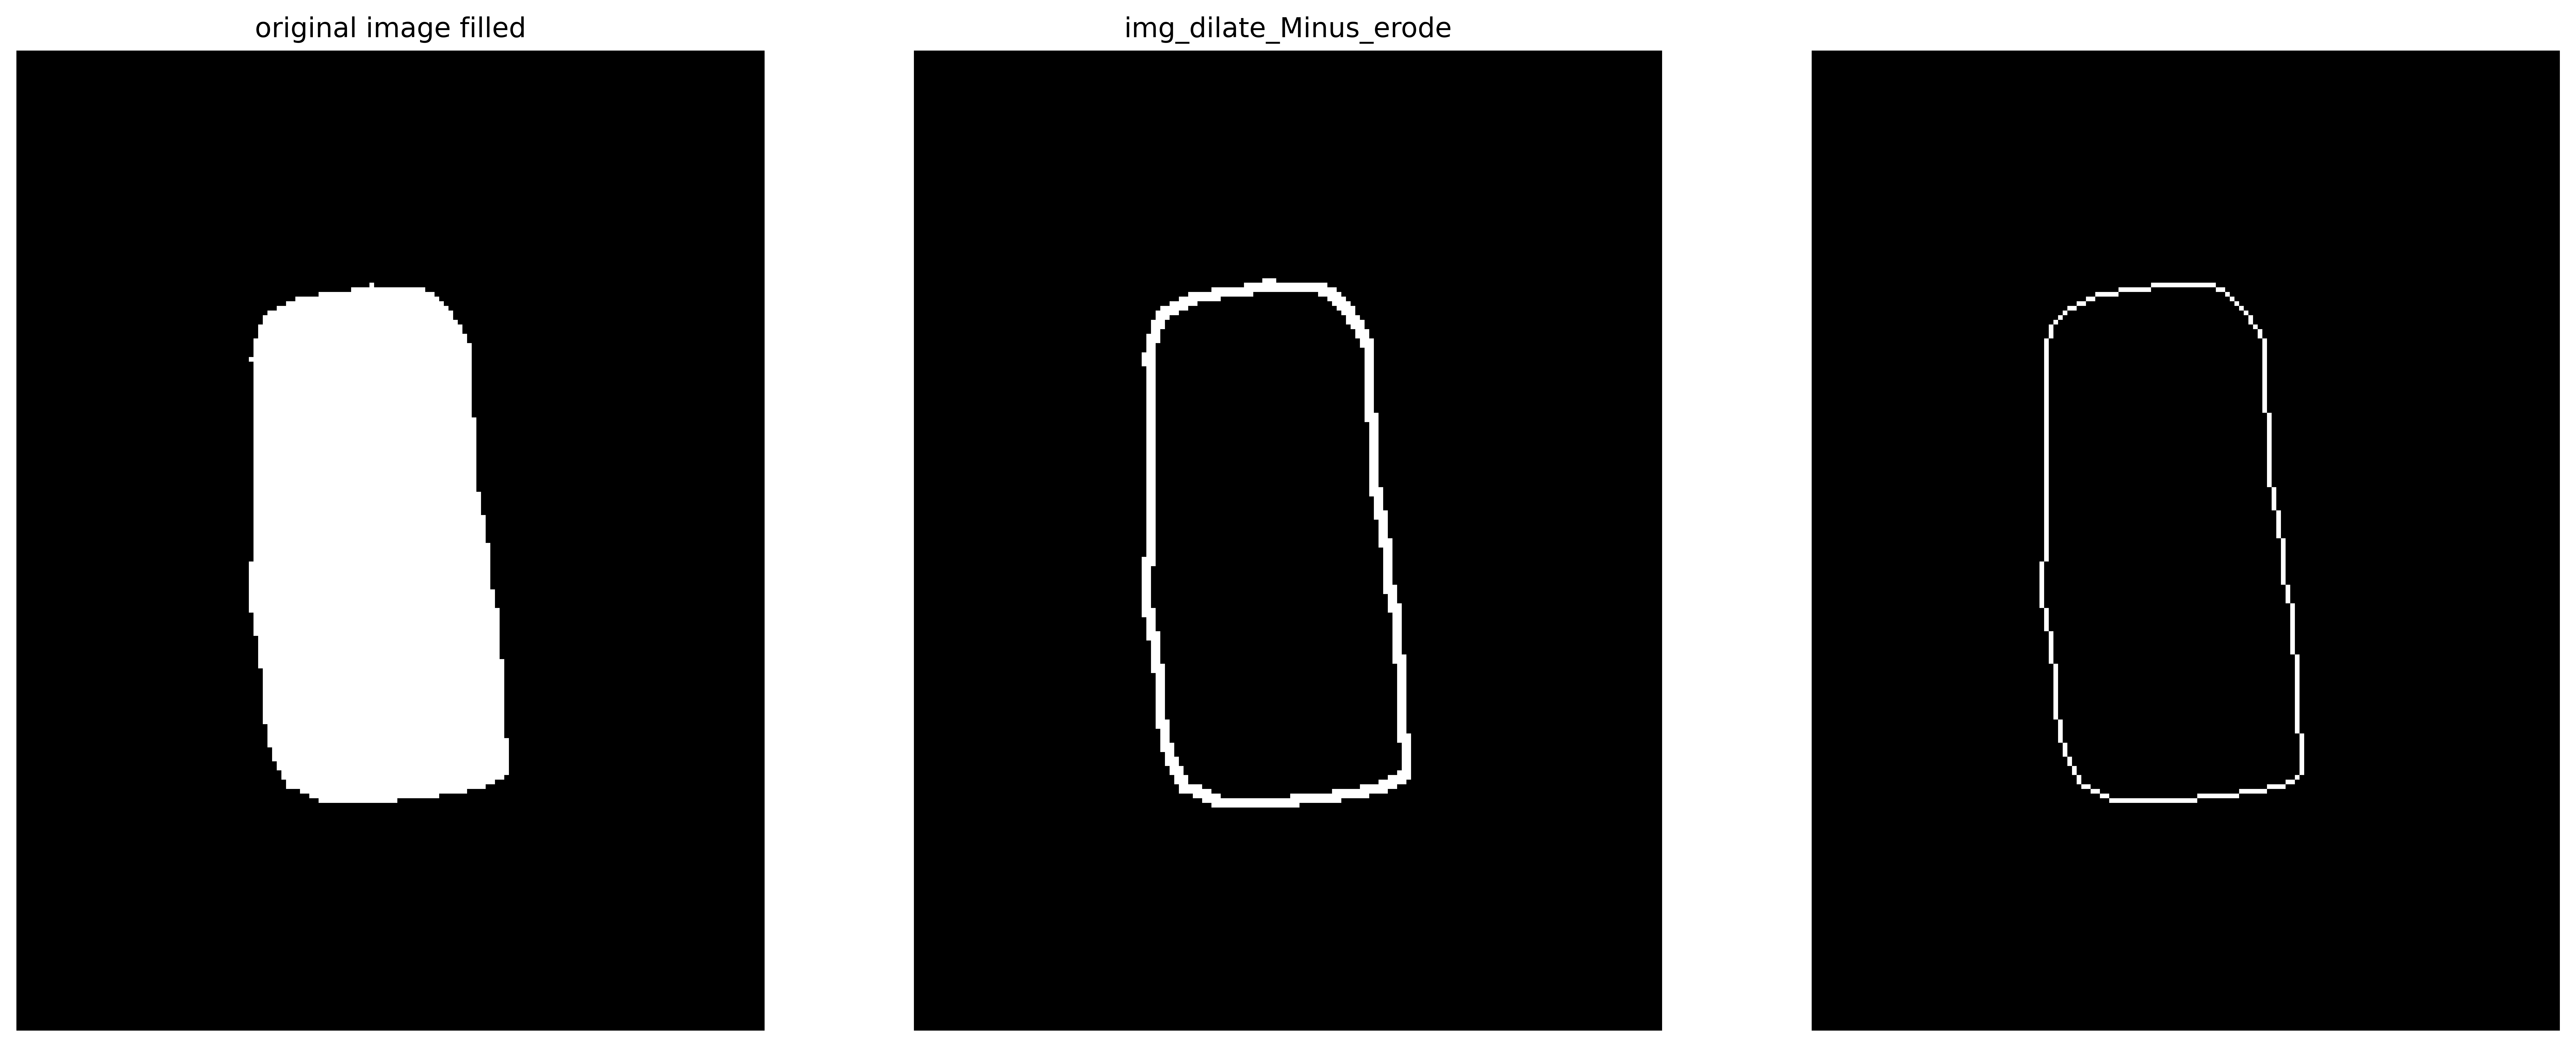

点形状： (23, 2)
面积： 1.125
点形状： (144, 2)
面积： 345.20625
原始的x_min, y_min 9335 29497
归一化后的x_min, y_min 50 50
endPoint: (1, 2)
交点个数： 1
端点个数： 1


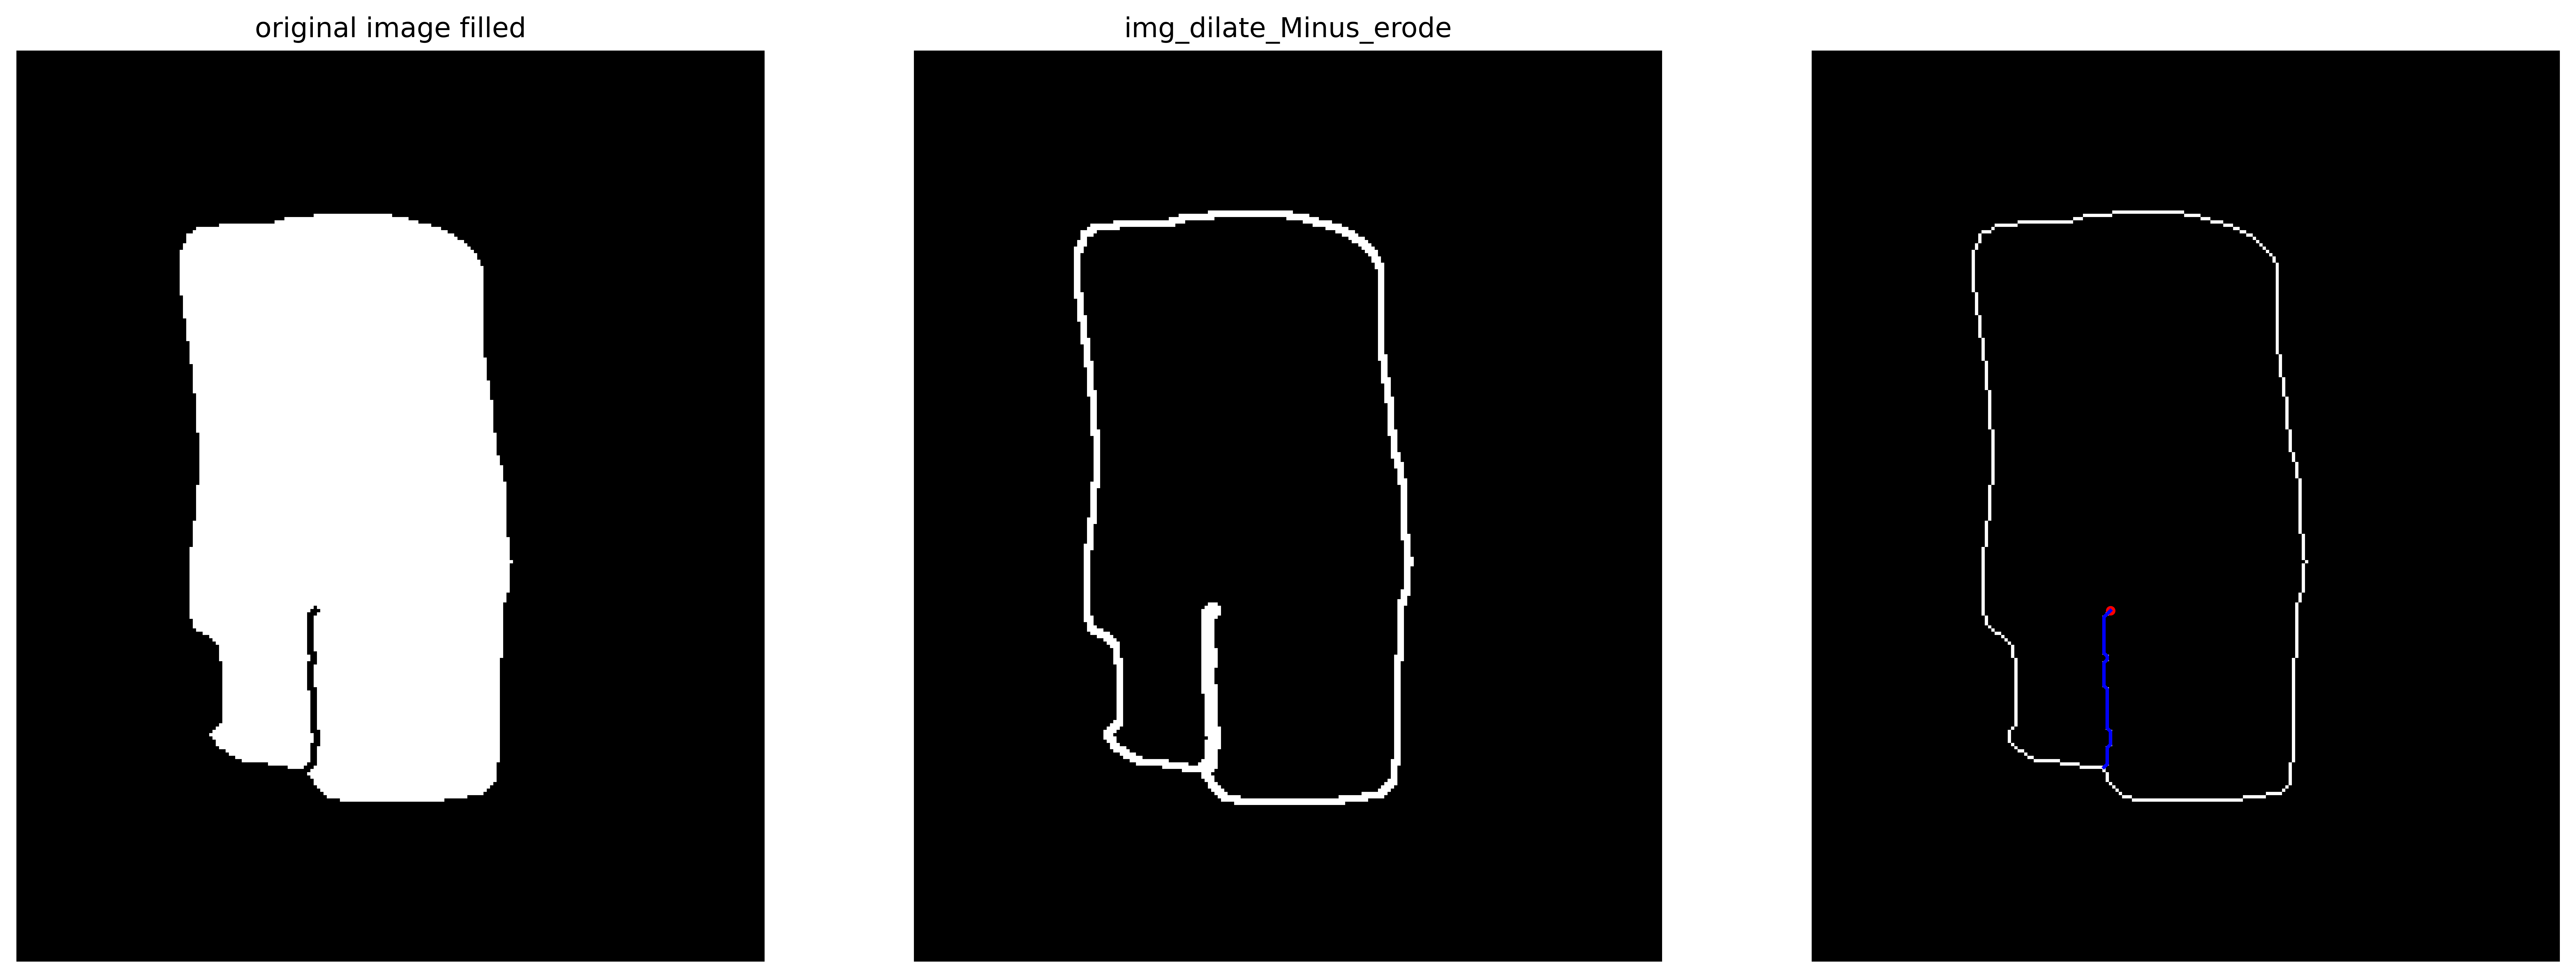

点形状： (46, 2)
面积： 5.9174999999999995
点形状： (580, 2)
面积： 7416.3825
原始的x_min, y_min 16250 29488
归一化后的x_min, y_min 50 50
endPoint: (1, 2)
交点个数： 1
端点个数： 1


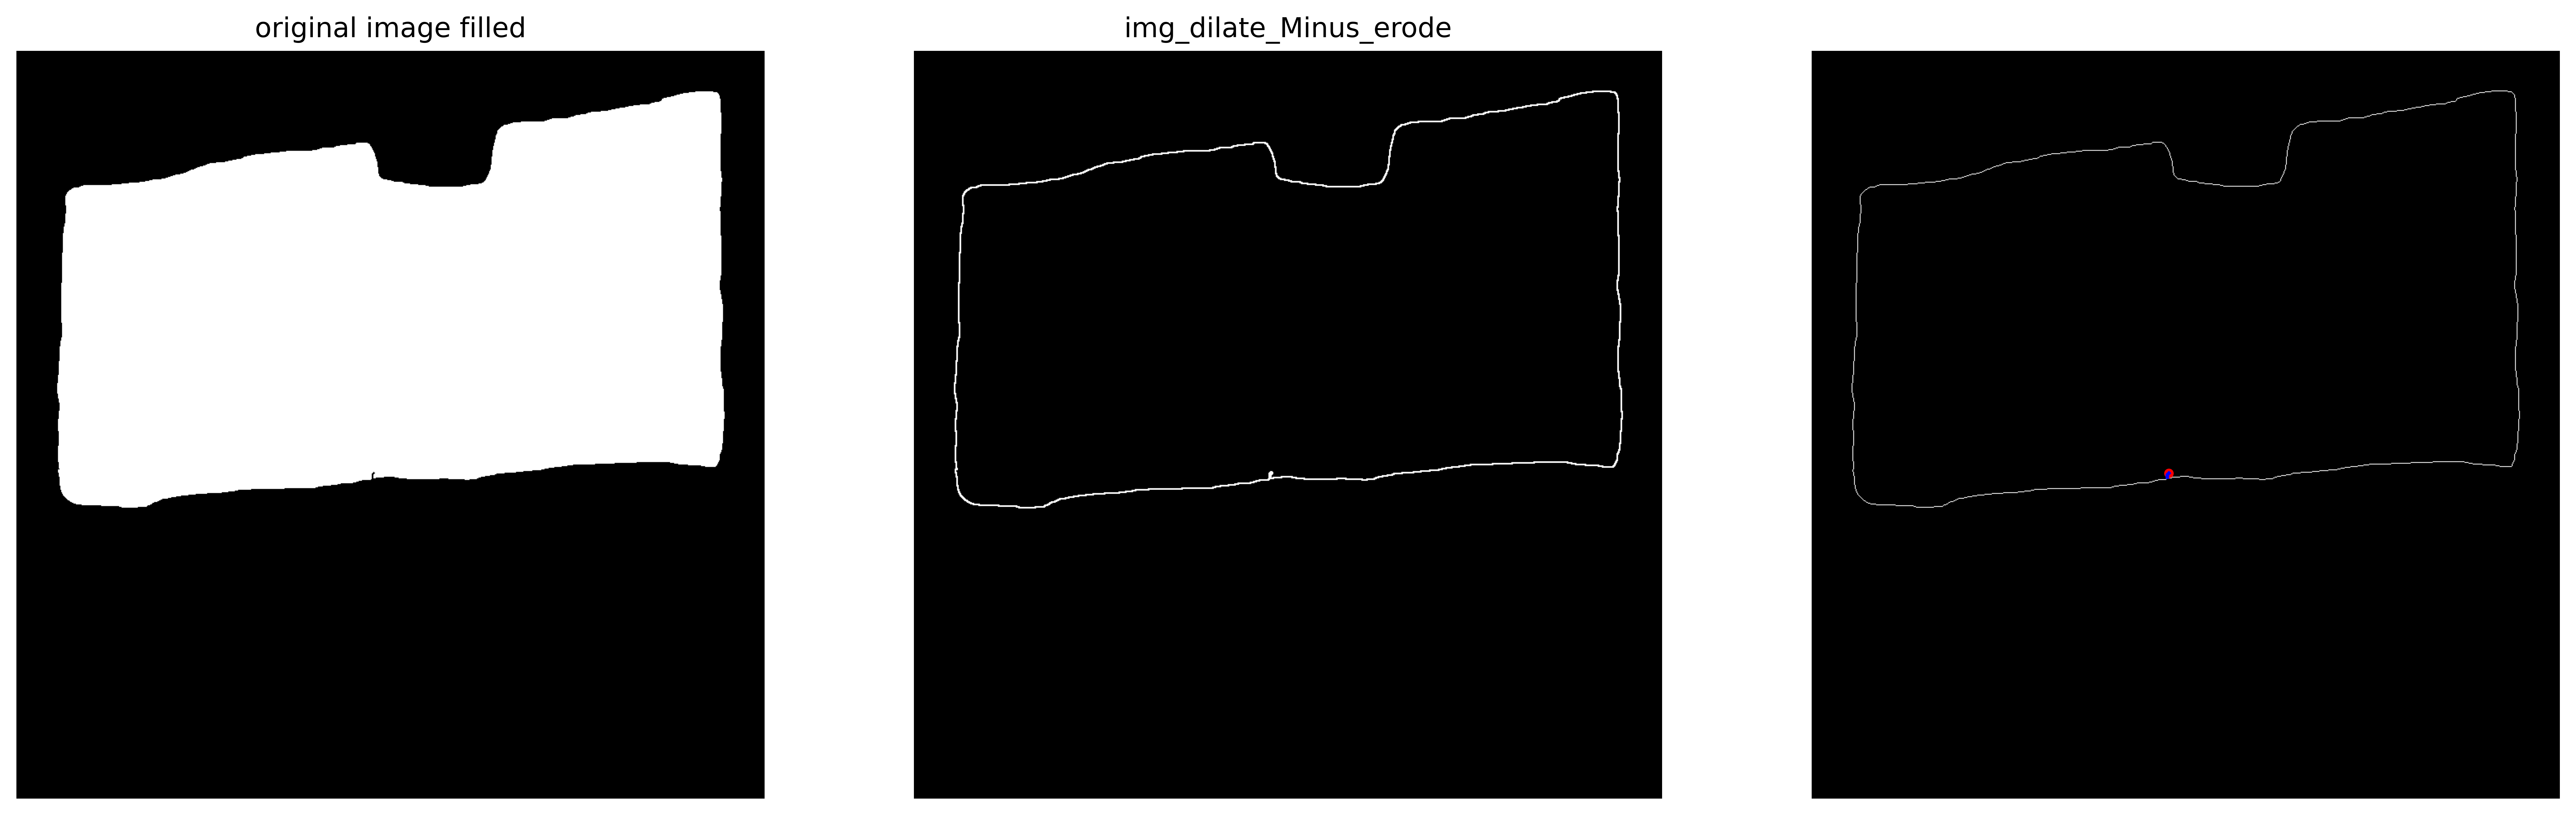

点形状： (156, 2)
面积： 150.8175
原始的x_min, y_min 14488 29487
归一化后的x_min, y_min 50 50
endPoint: (1, 2)
交点个数： 1
端点个数： 1


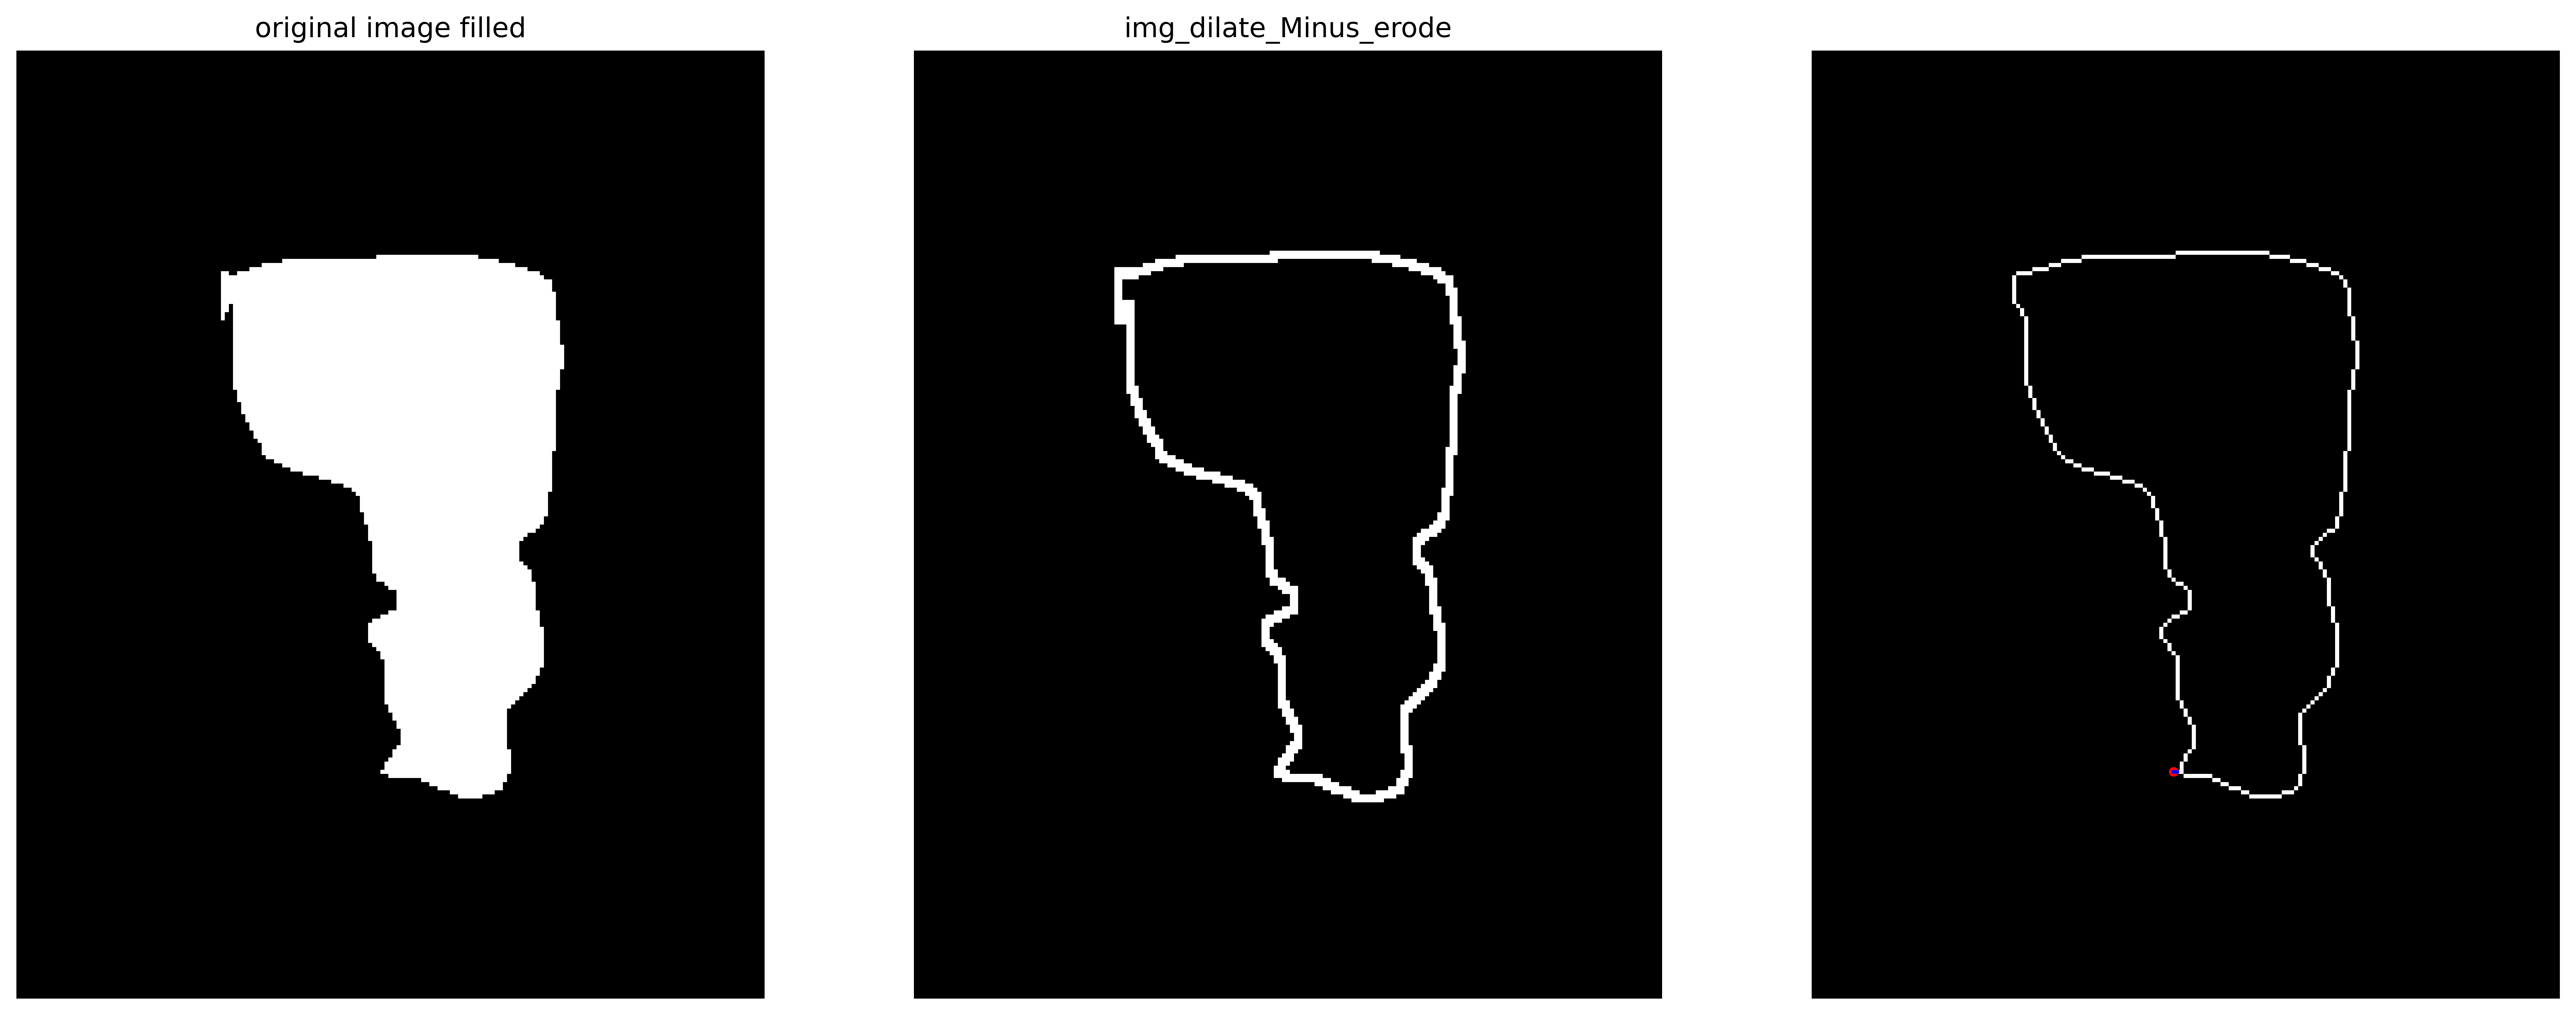

点形状： (29, 2)
面积： 0.9674999999999999
点形状： (79, 2)
面积： 55.192499999999995
原始的x_min, y_min 14412 29485
归一化后的x_min, y_min 50 50
endPoint: (1, 2)
交点个数： 1
端点个数： 1


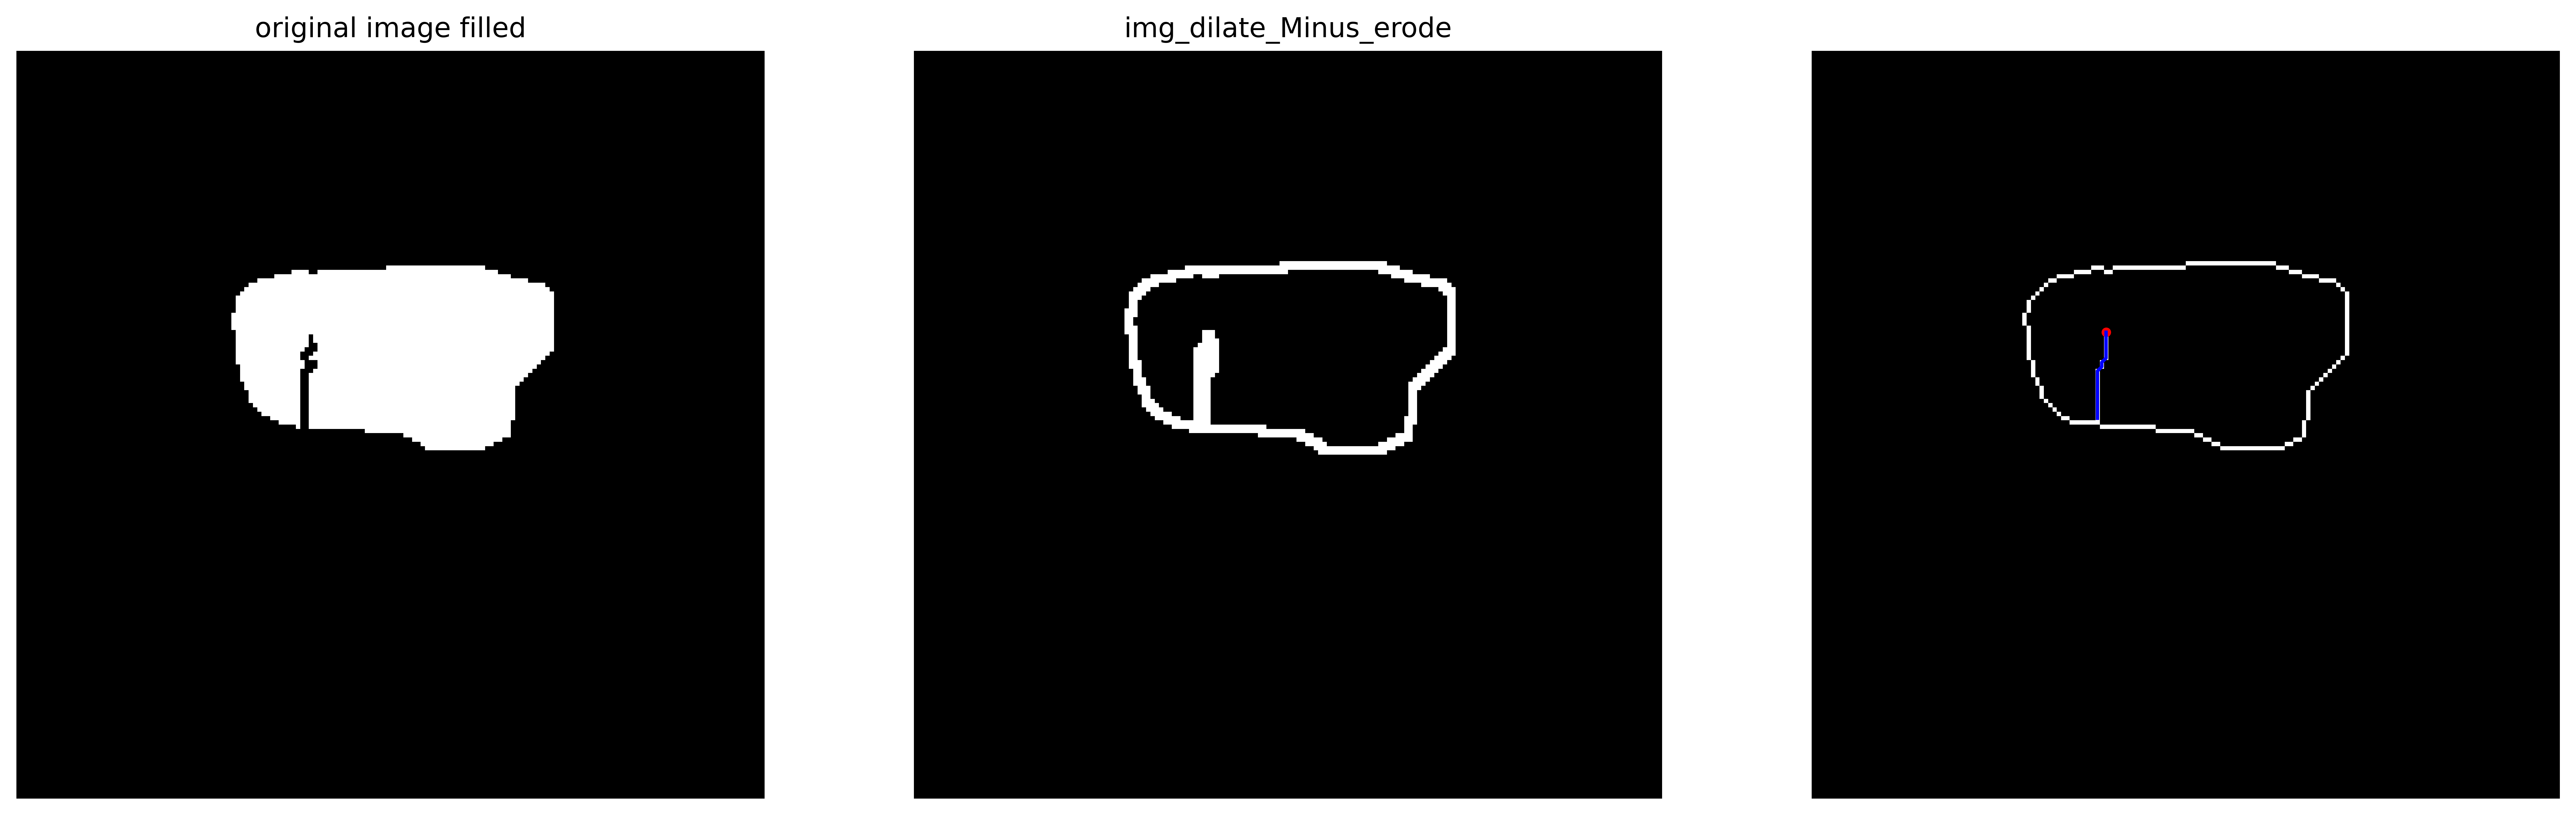

点形状： (27, 2)
面积： 12.667499999999999
点形状： (54, 2)
面积： 1.755
点形状： (170, 2)
面积： 381.51
原始的x_min, y_min 13498 29475
归一化后的x_min, y_min 50 50
endPoint: (3, 2)
交点个数： 3
端点个数： 3


/home/Garfield/.conda/envs/pt37/lib/python3.7/site-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


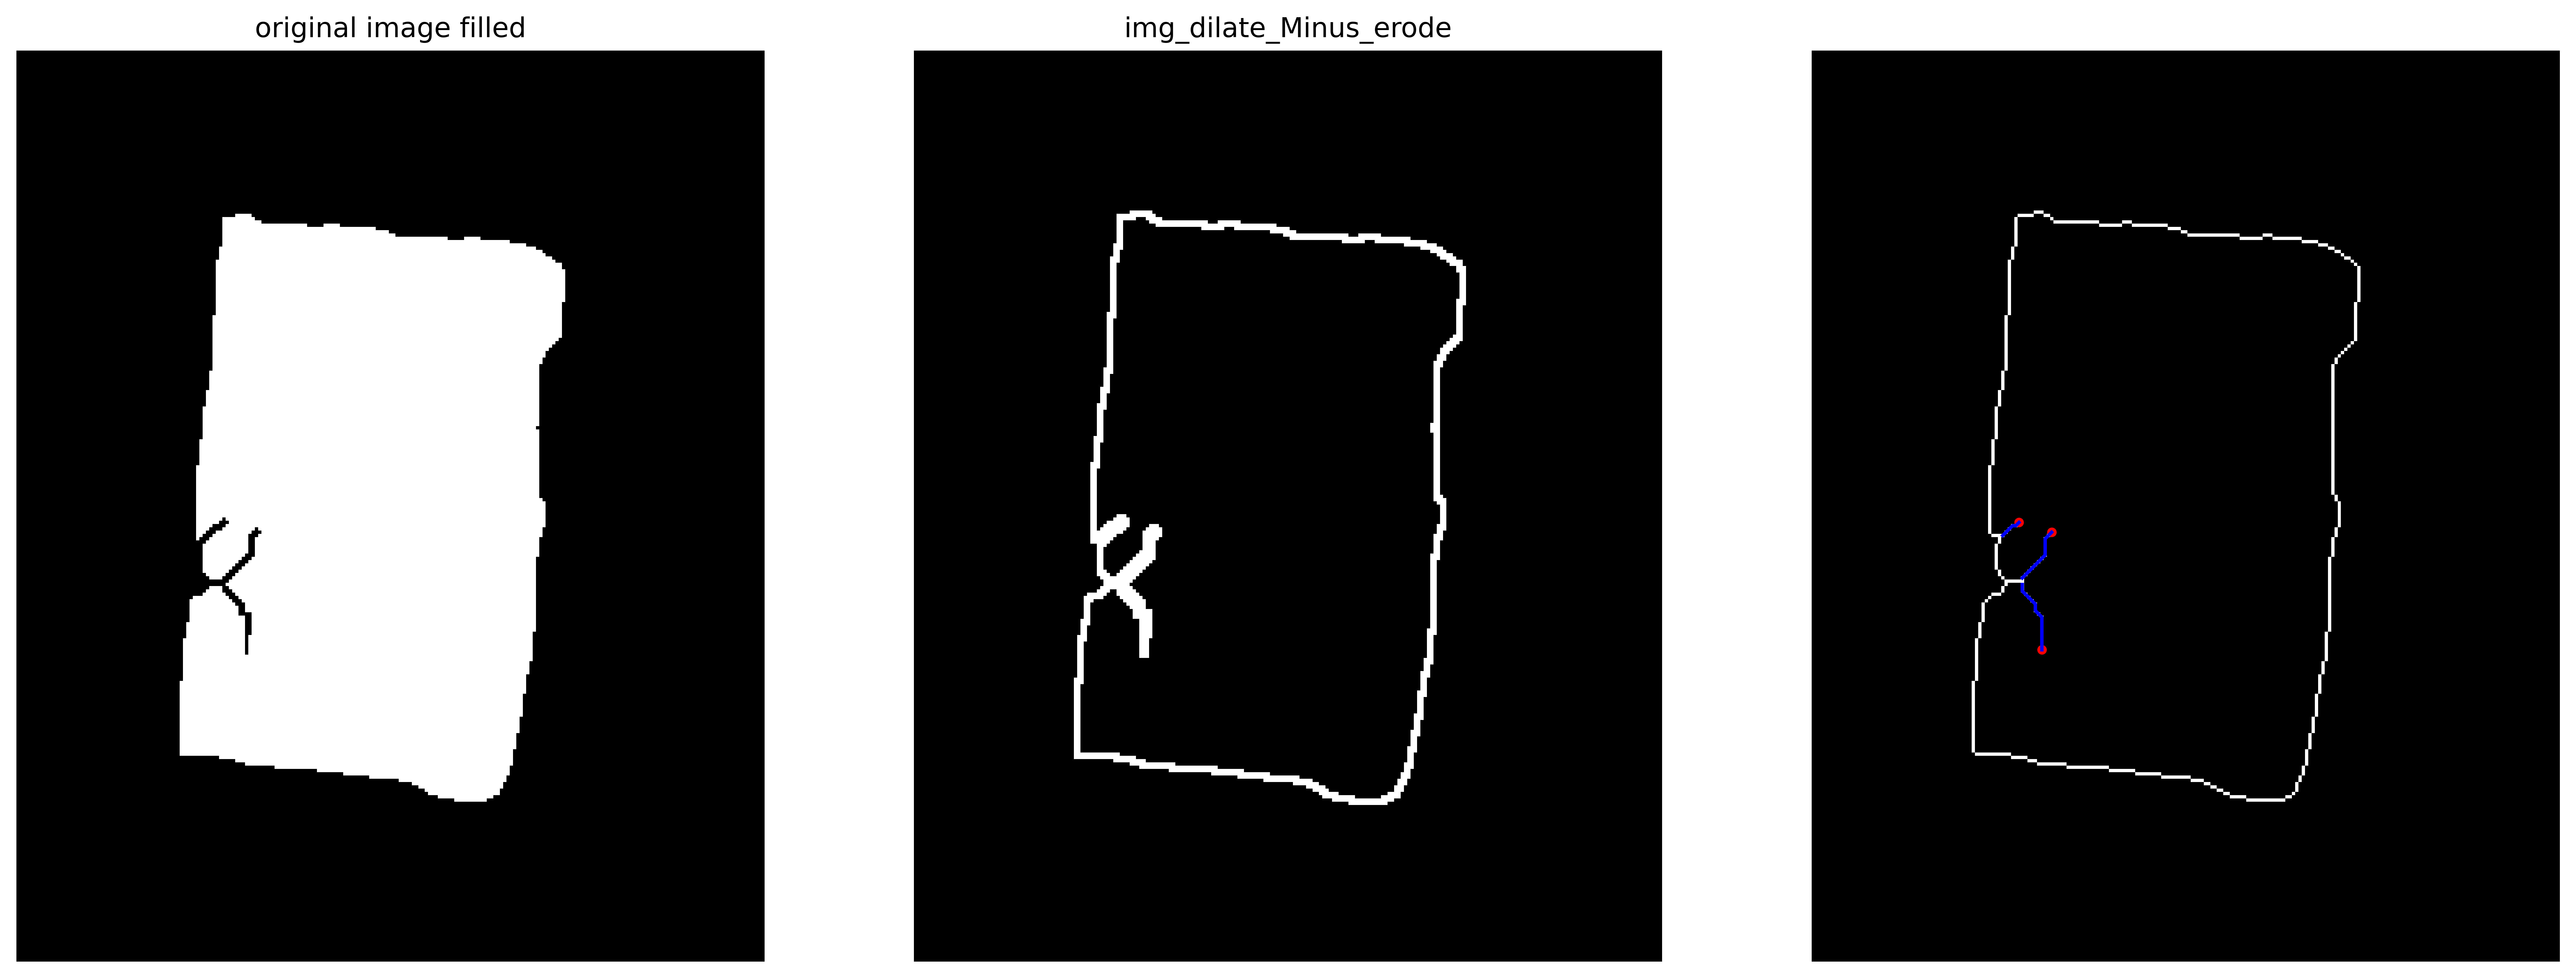

点形状： (295, 2)
面积： 493.93125
原始的x_min, y_min 3060 29463
归一化后的x_min, y_min 50 50
endPoint: (0,)


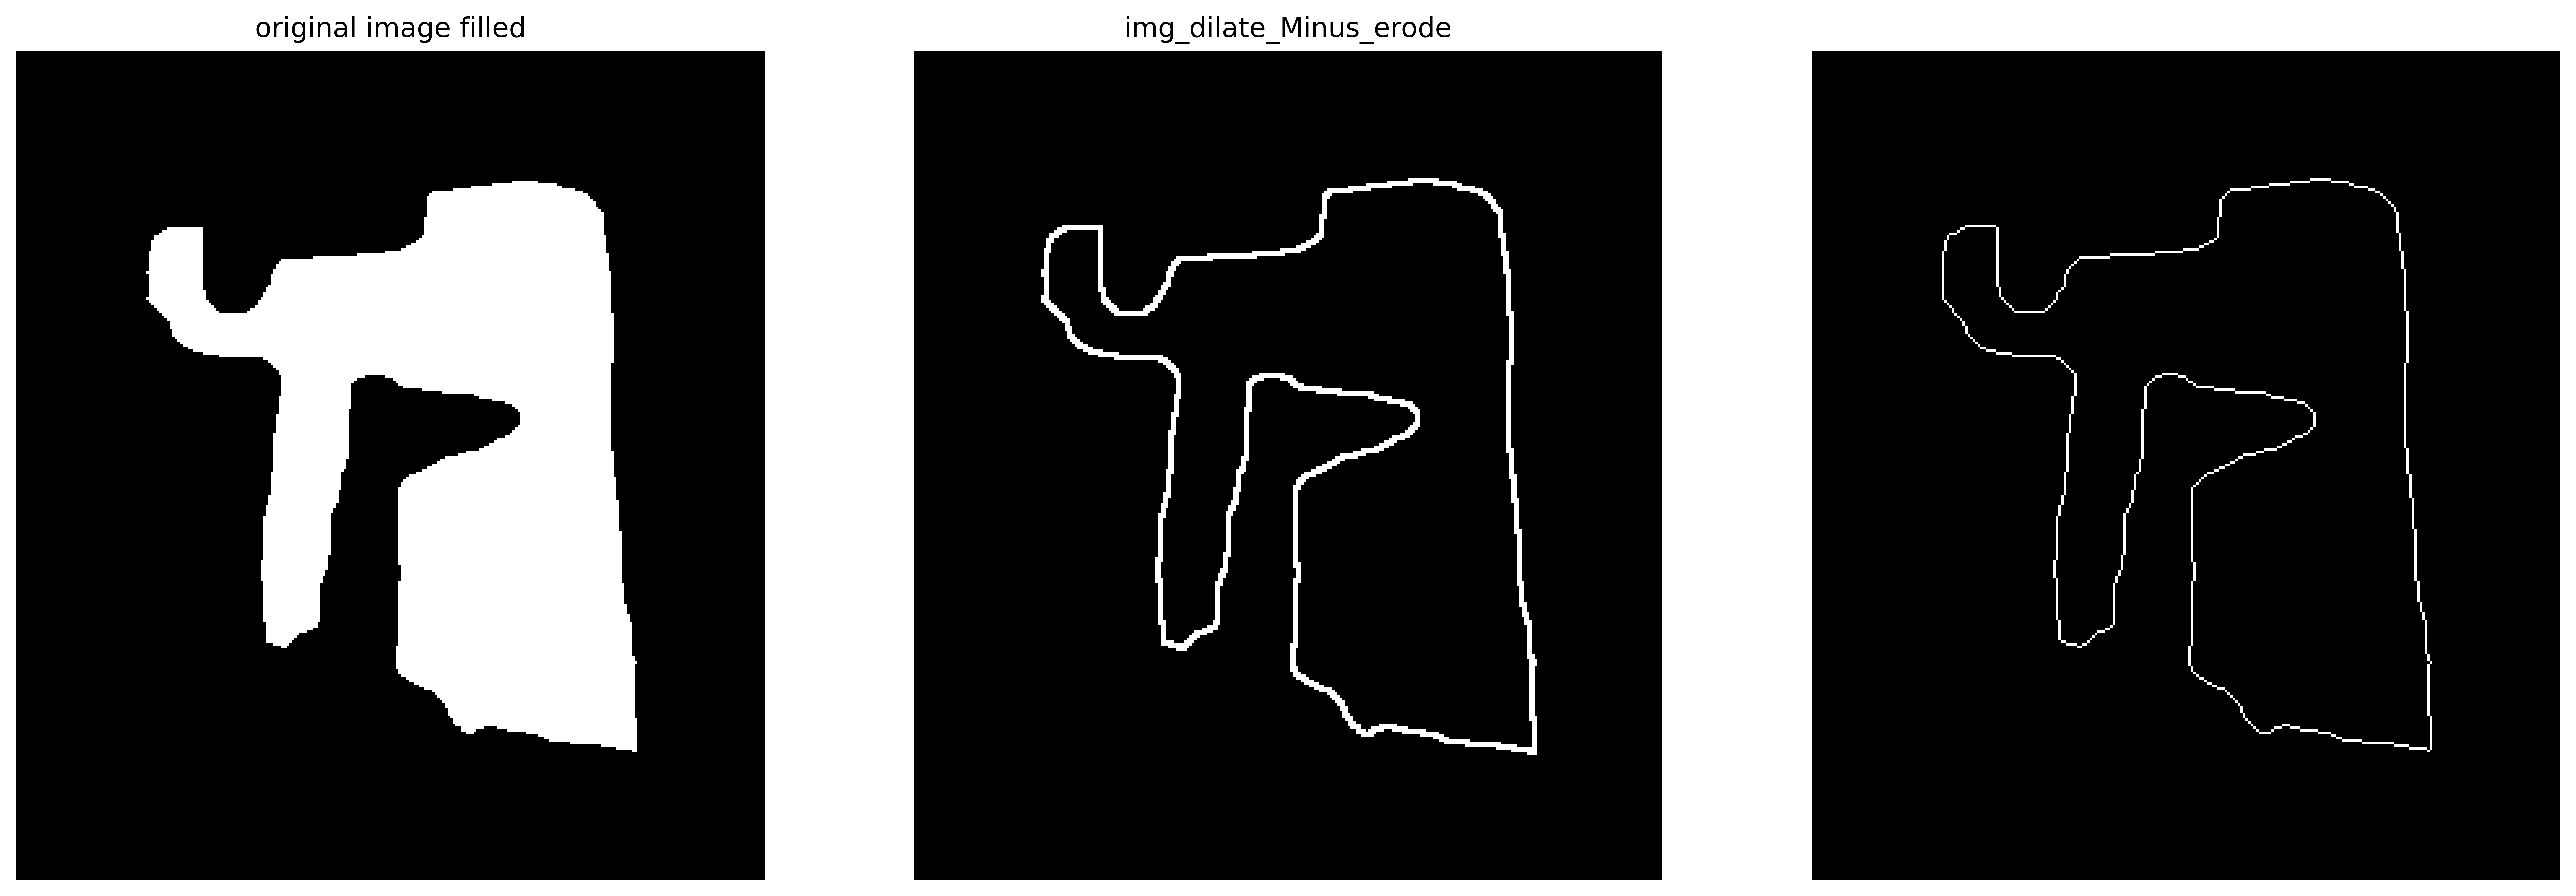

点形状： (218, 2)
面积： 50.18625
原始的x_min, y_min 14829 29462
归一化后的x_min, y_min 50 50
endPoint: (2, 2)
交点个数： 2
端点个数： 2


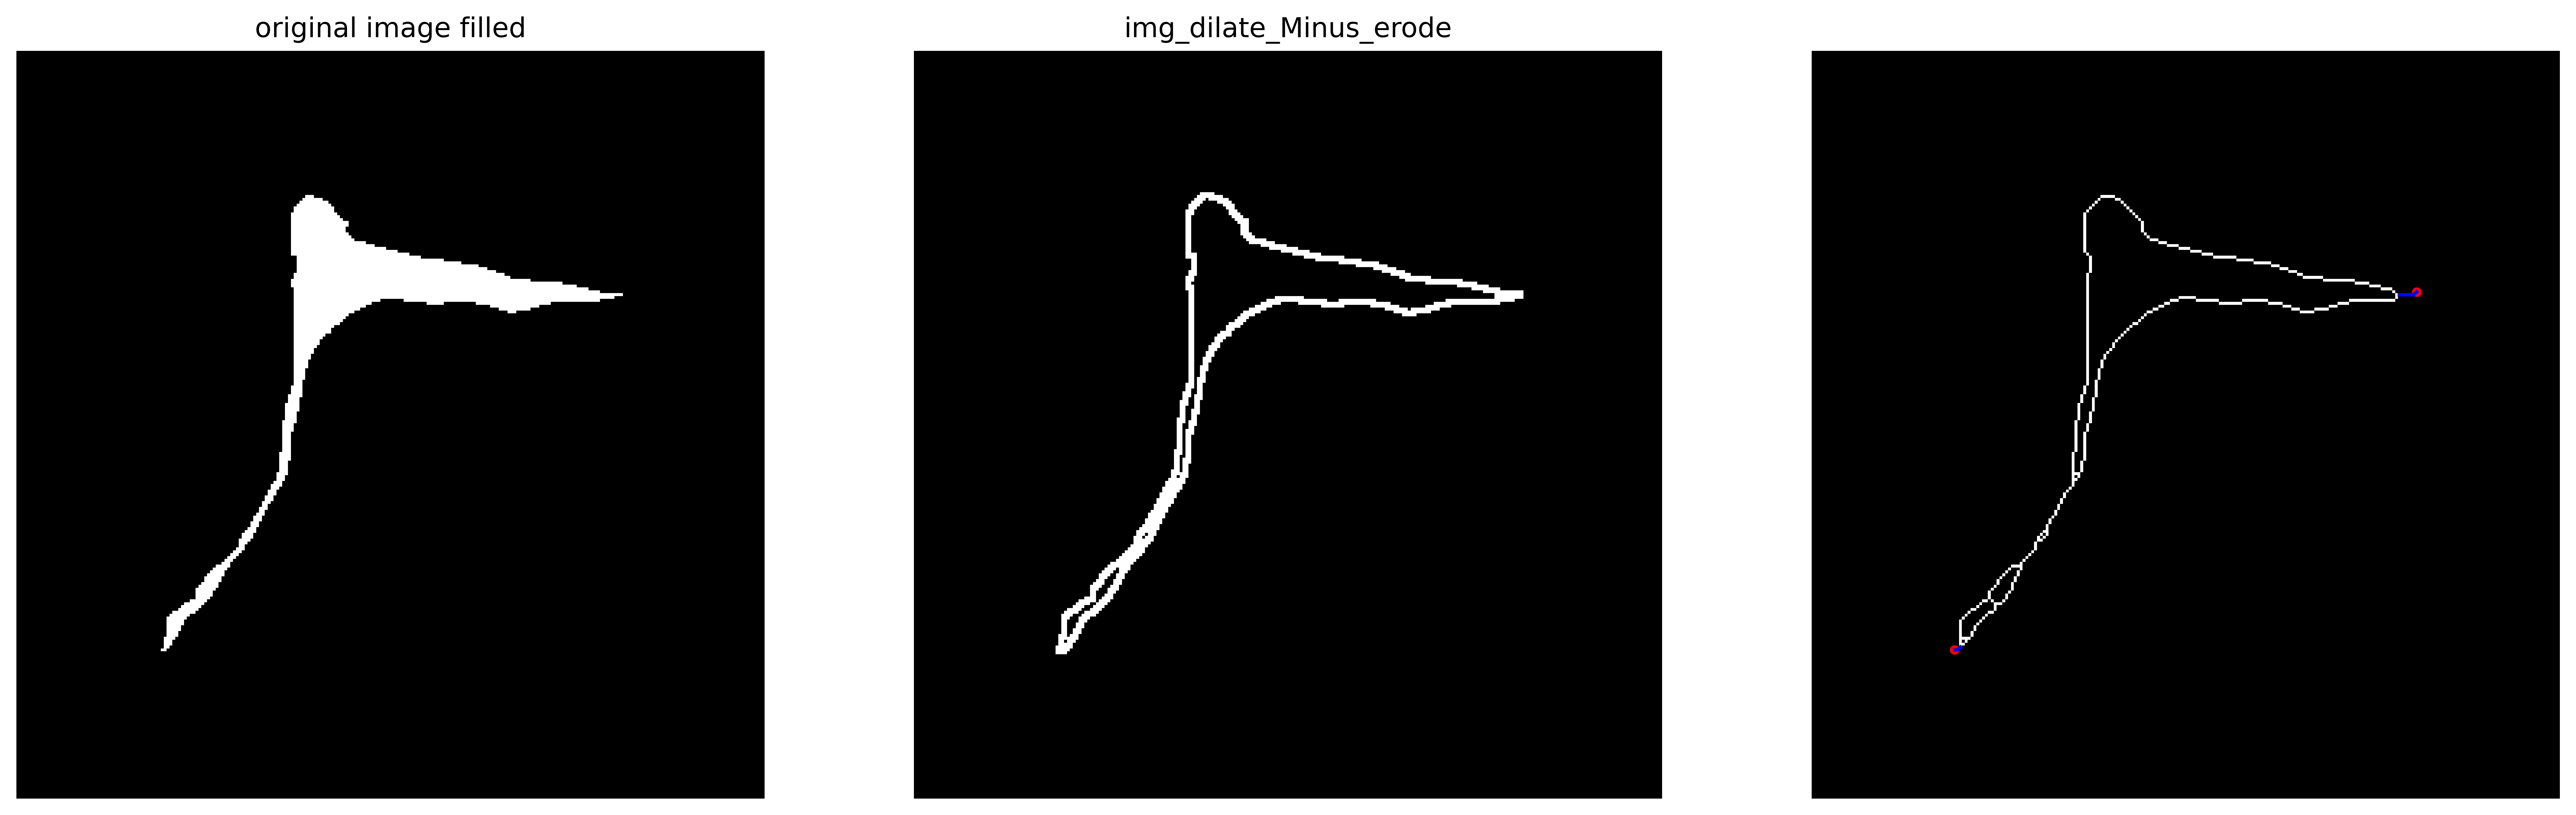

点形状： (62, 2)
面积： 78.73875
原始的x_min, y_min 9715 29462
归一化后的x_min, y_min 50 50
endPoint: (1, 2)
交点个数： 1
端点个数： 1


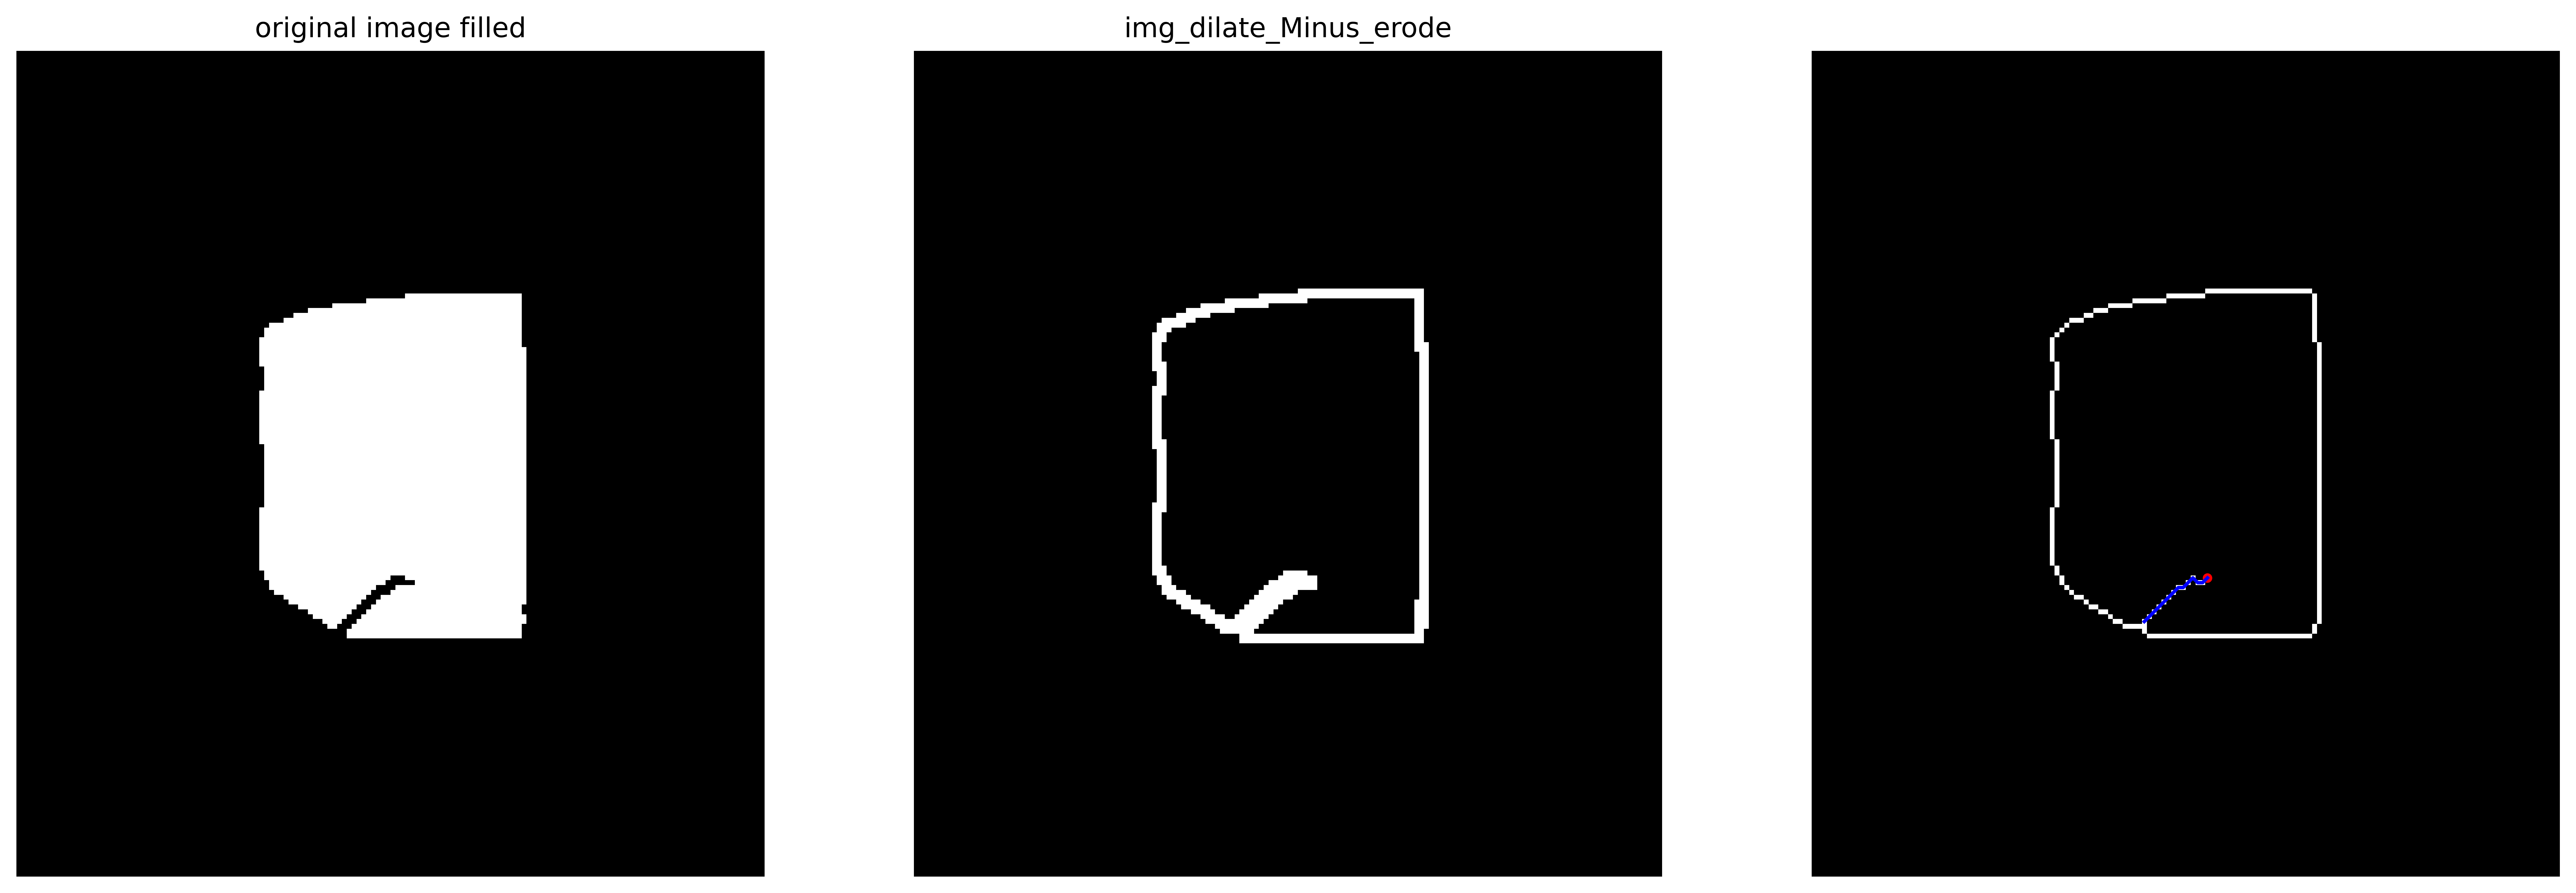

点形状： (108, 2)
面积： 64.66499999999999
原始的x_min, y_min 2035 29457
归一化后的x_min, y_min 50 50
endPoint: (0,)


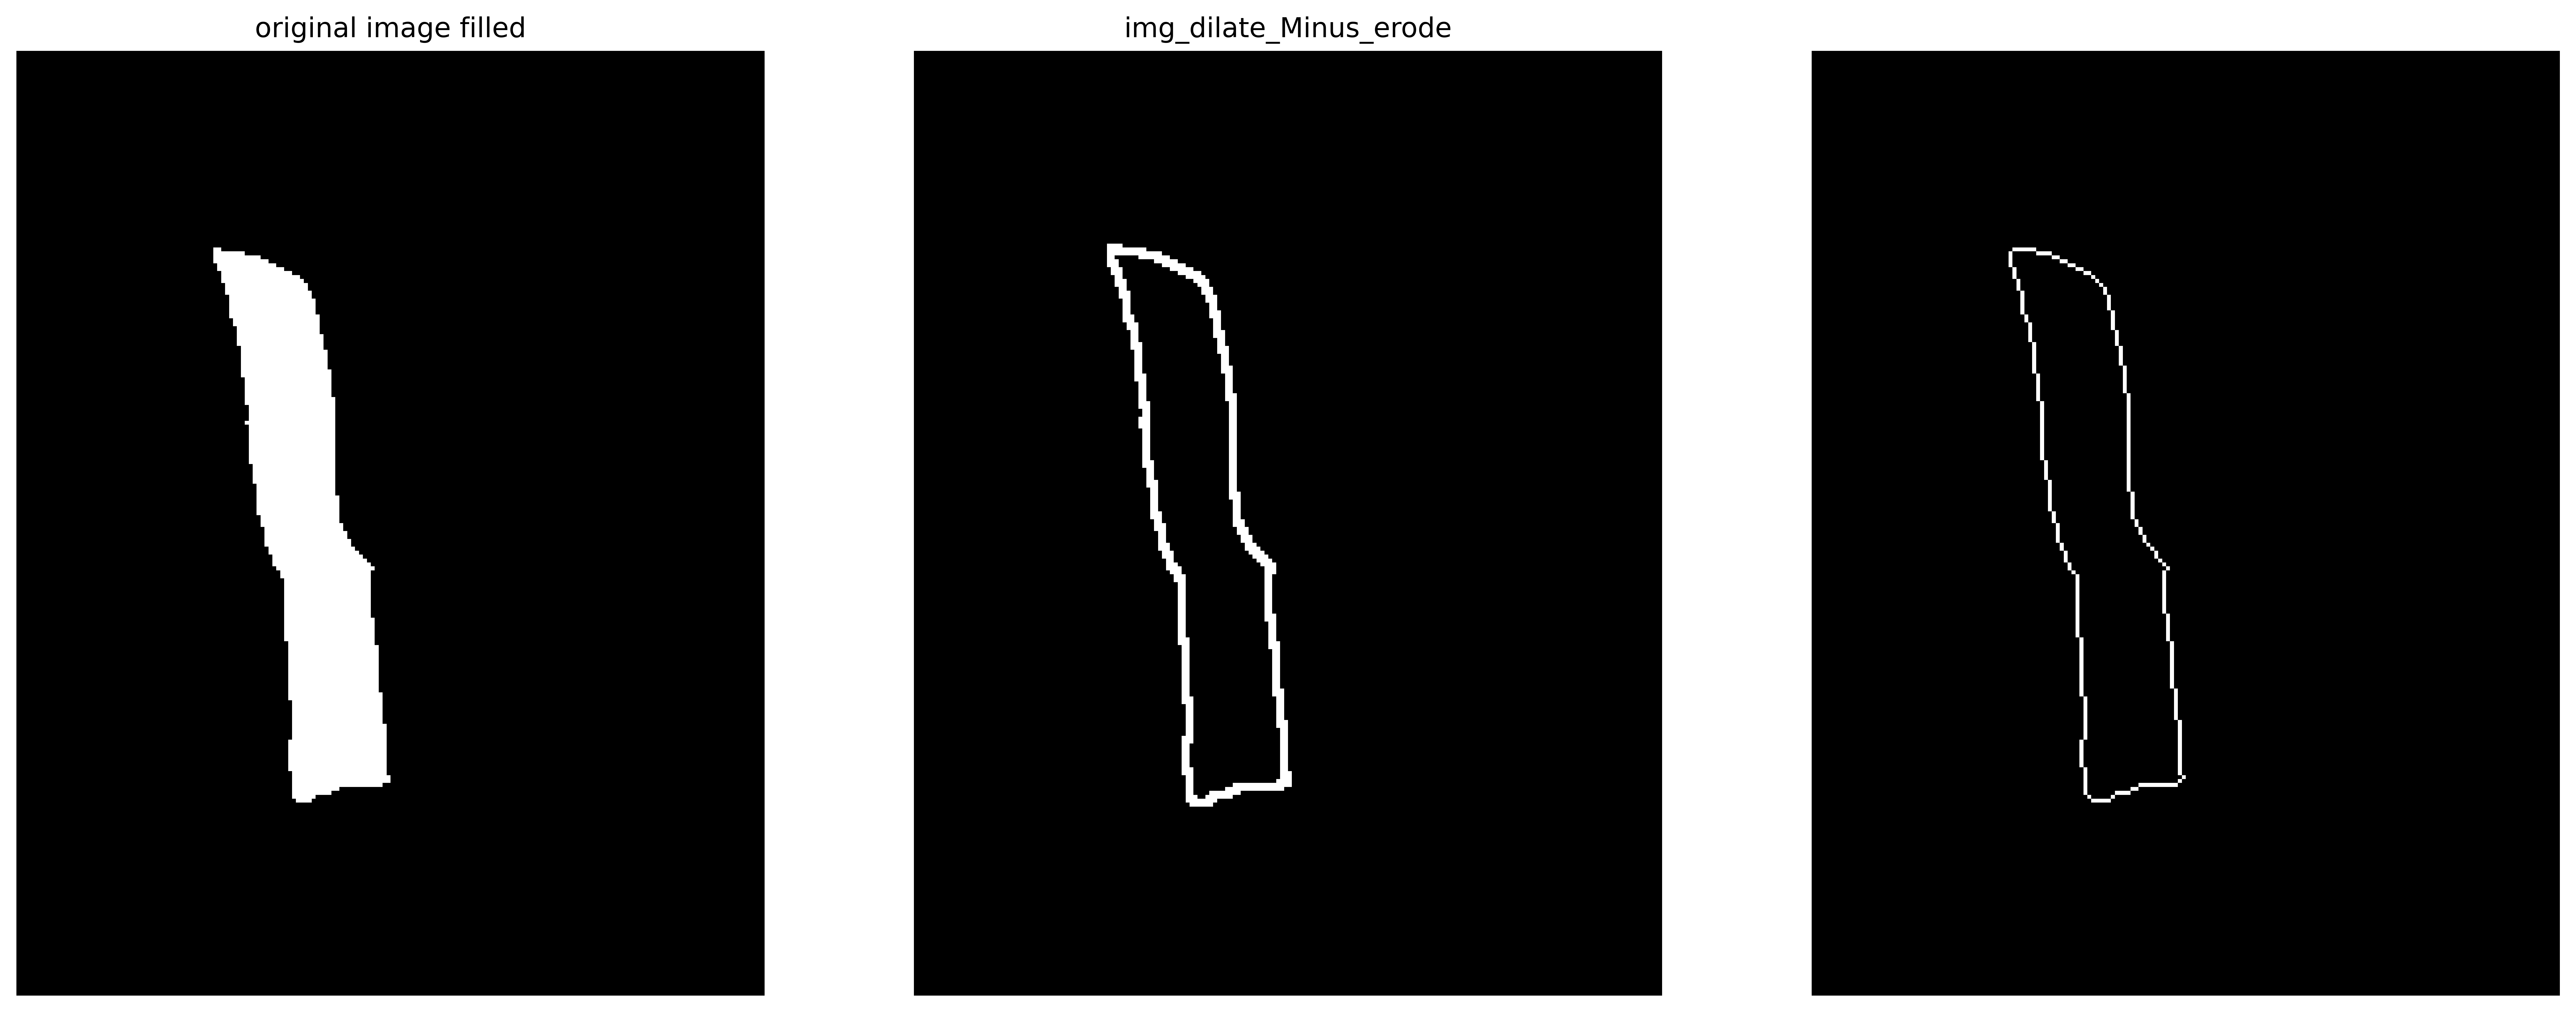

点形状： (38, 2)
面积： 7.9425
点形状： (133, 2)
面积： 151.2
原始的x_min, y_min 16257 29452
归一化后的x_min, y_min 50 50
endPoint: (0,)


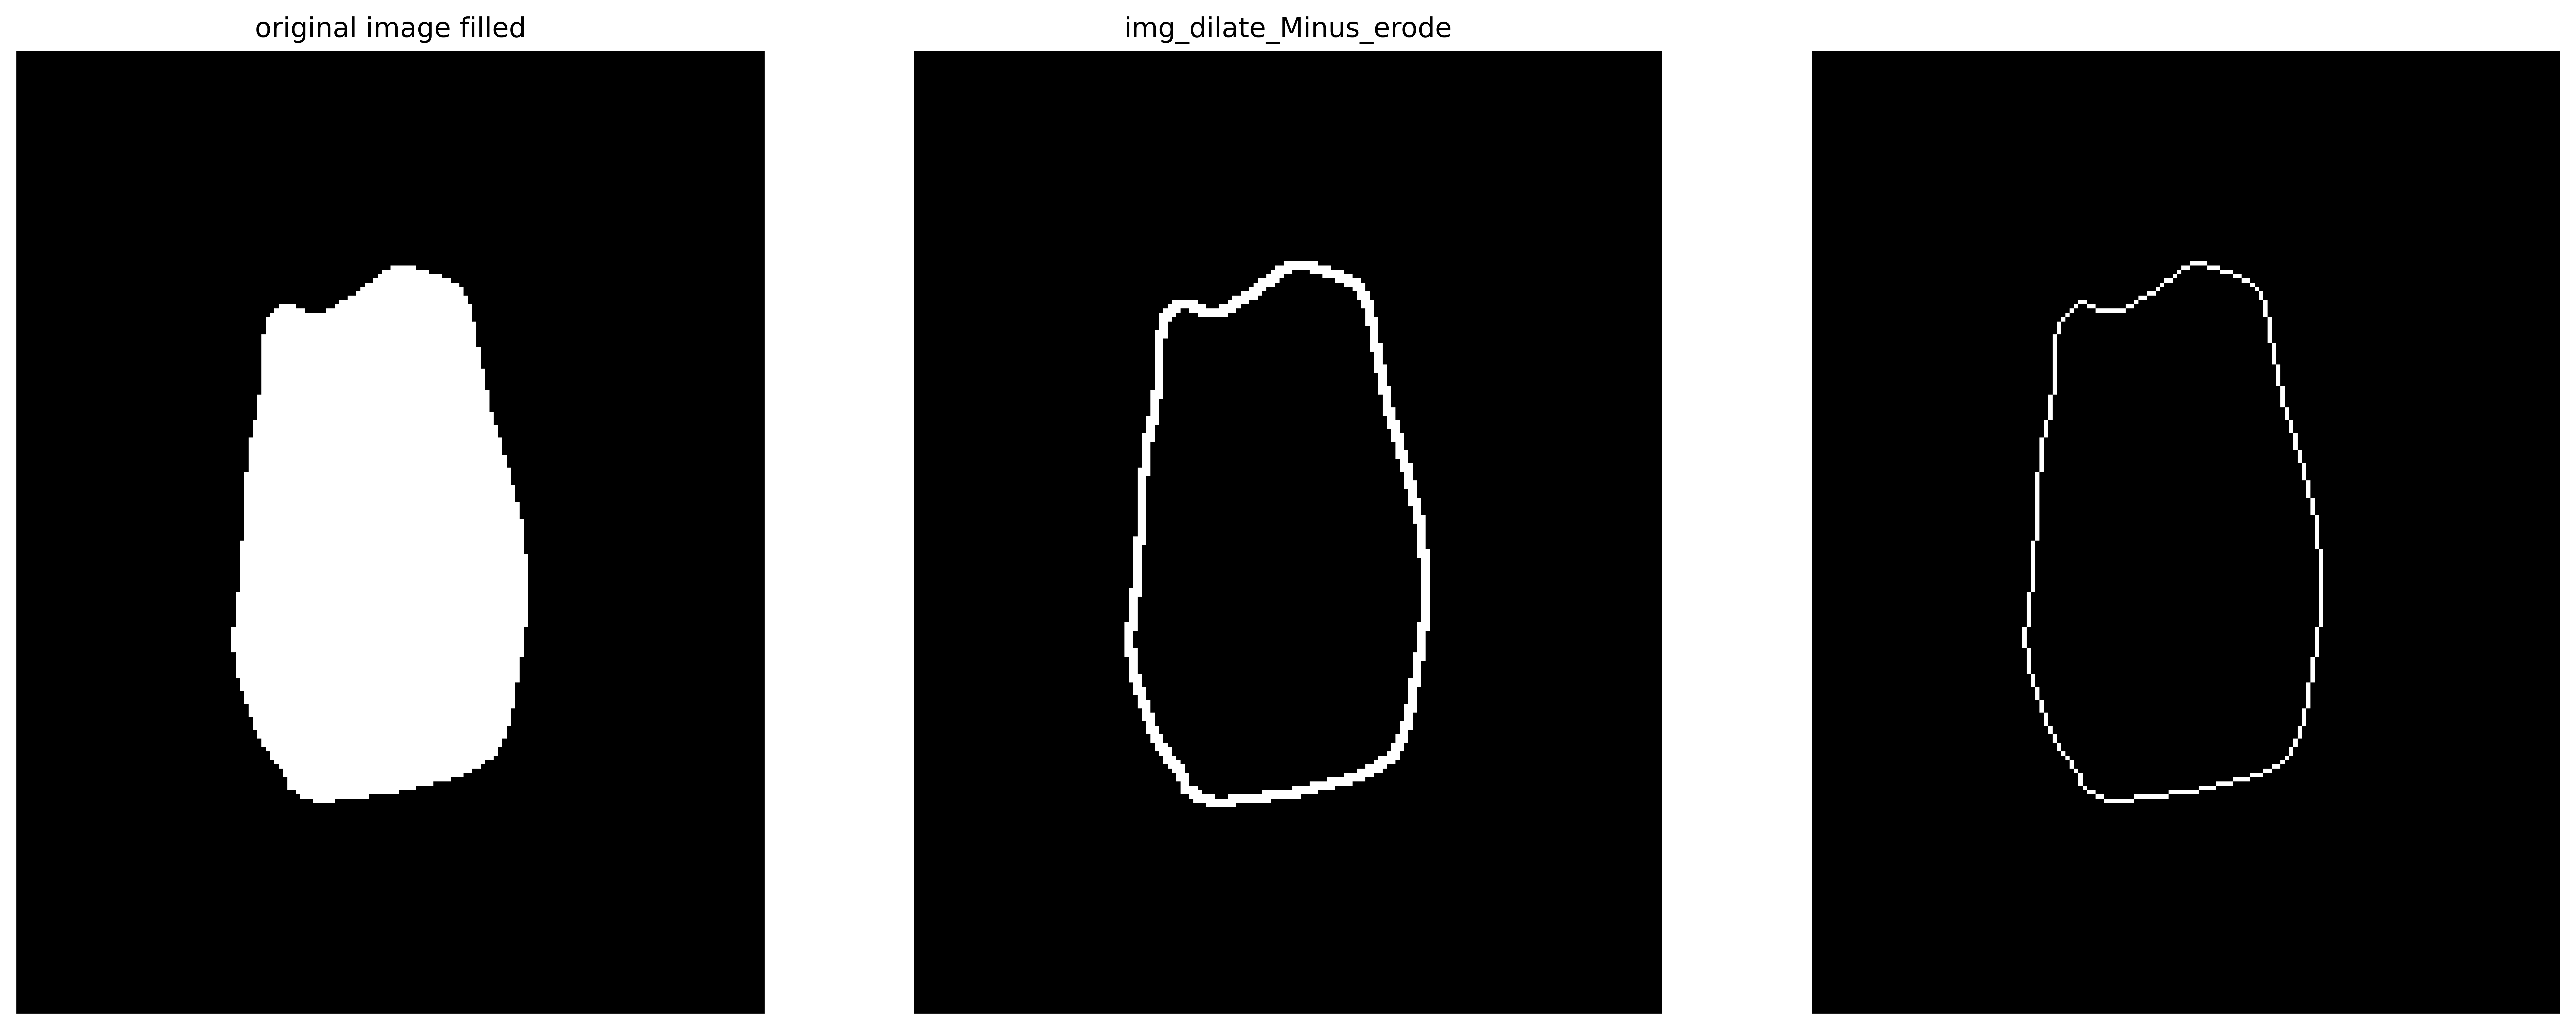

点形状： (84, 2)
面积： 14.366249999999999
原始的x_min, y_min 3108 29452
归一化后的x_min, y_min 50 50
endPoint: (2, 2)
交点个数： 2
端点个数： 2


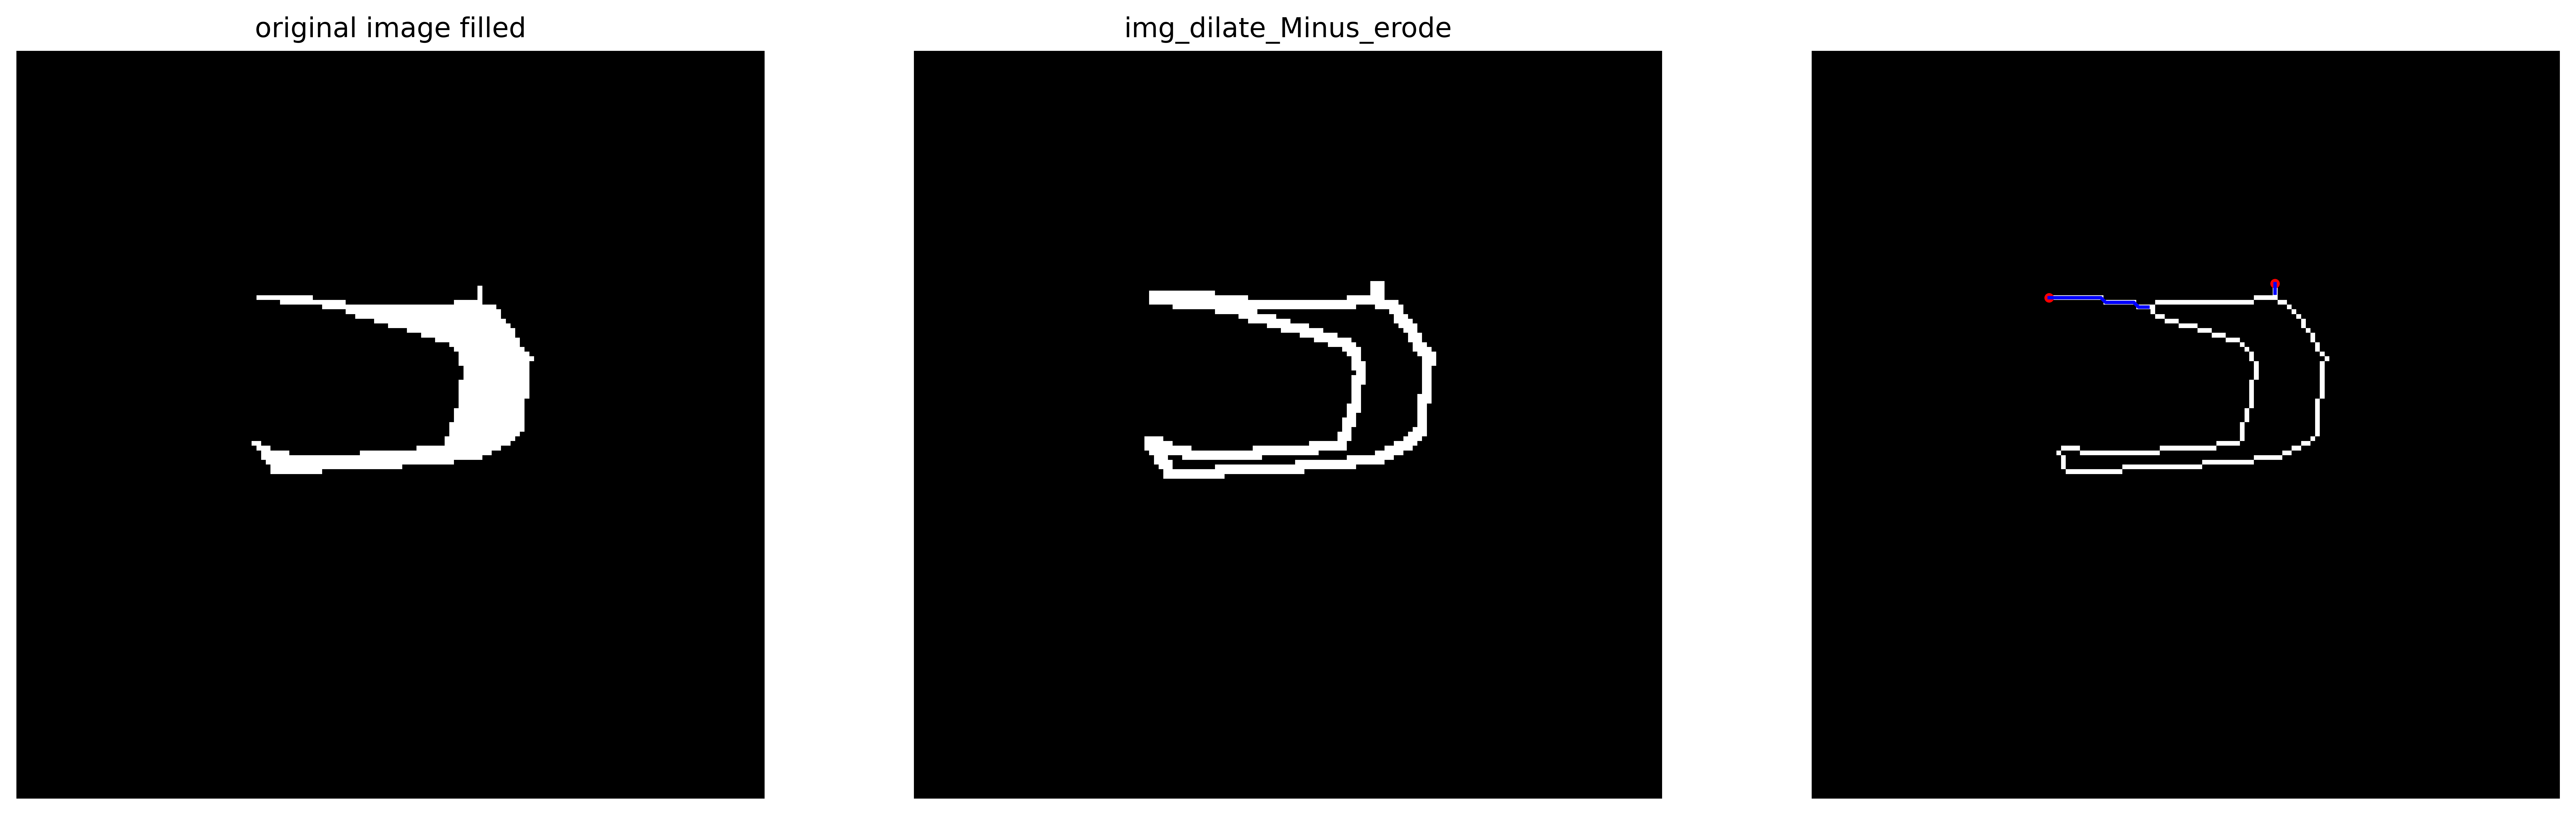

点形状： (367, 2)
面积： 3685.3424999999997
原始的x_min, y_min 17098 29443
归一化后的x_min, y_min 50 50
endPoint: (2, 2)
交点个数： 2
端点个数： 2


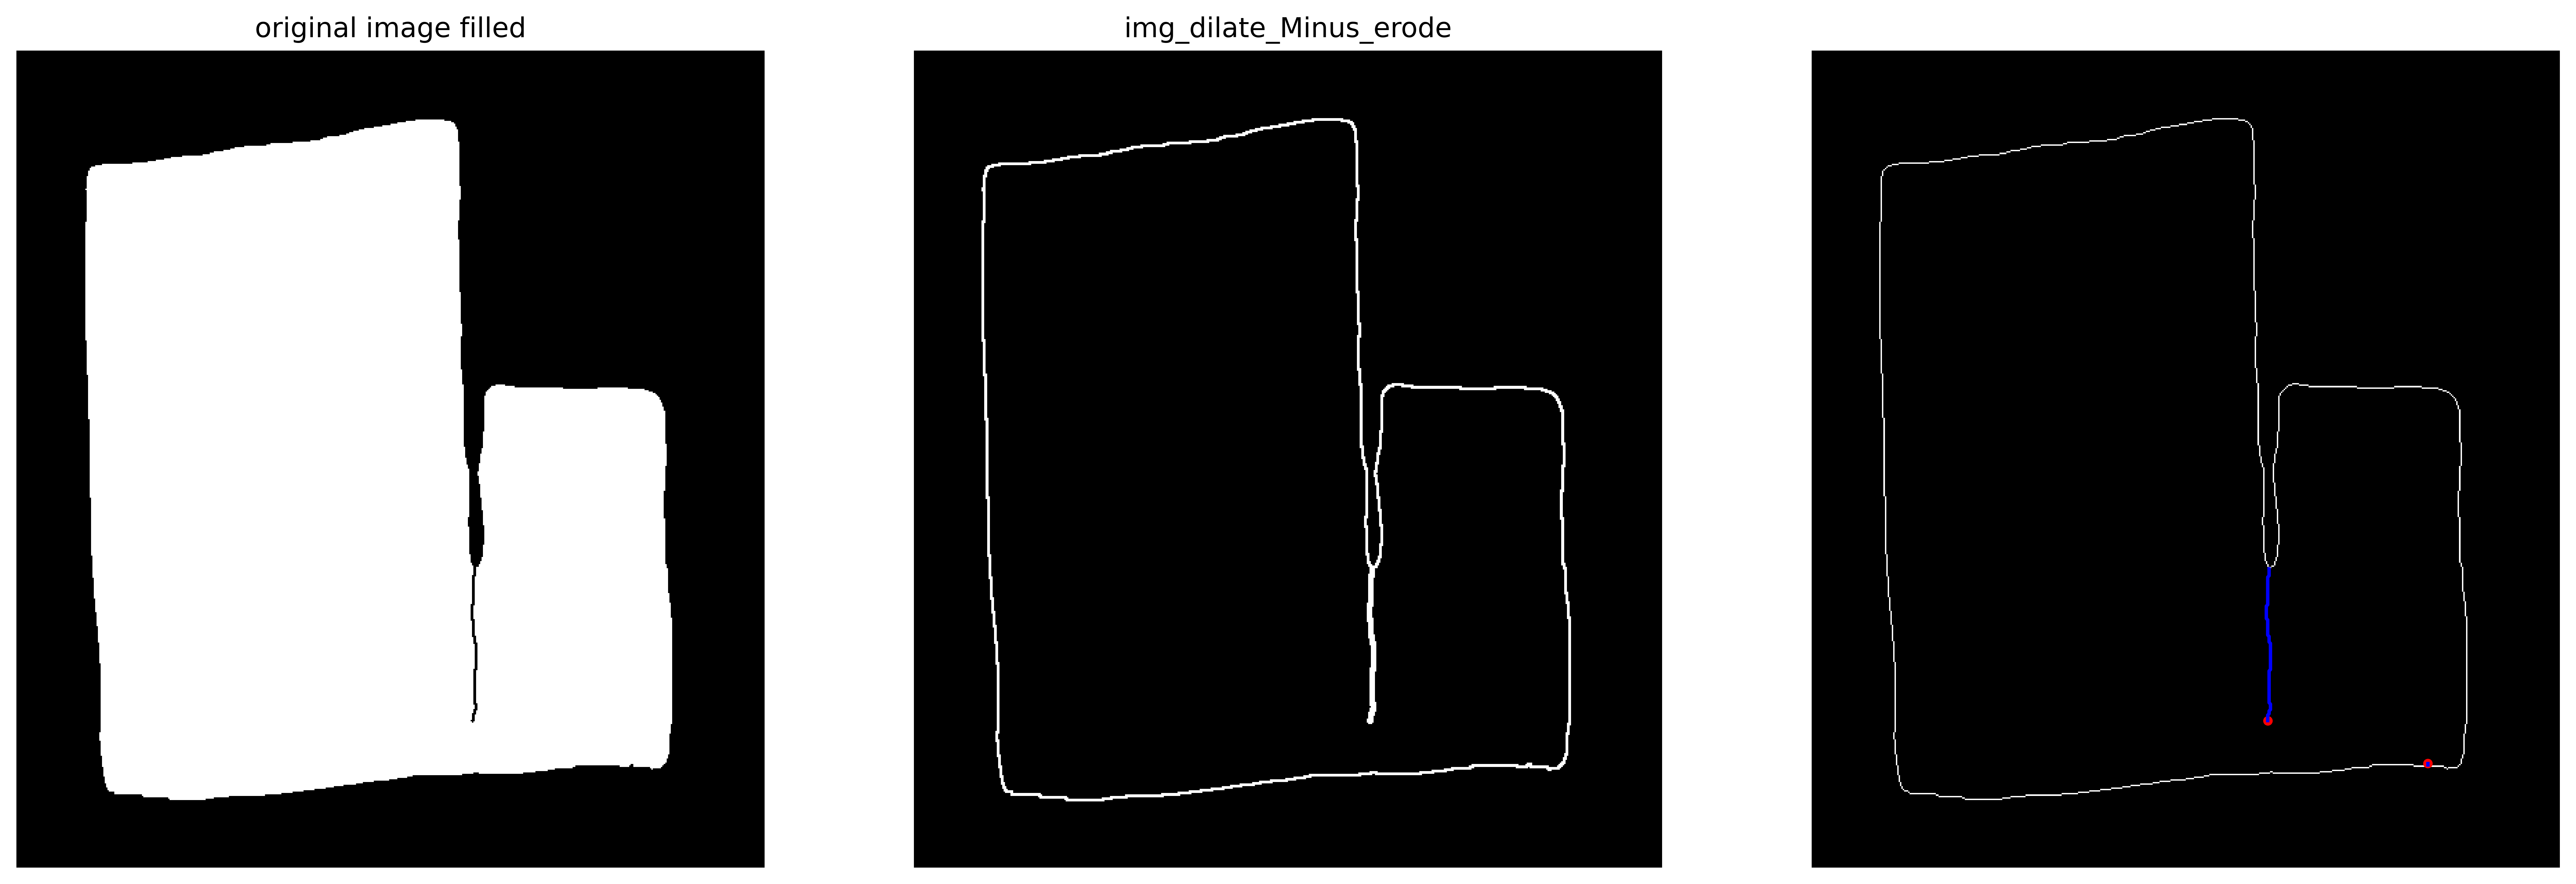

In [22]:
# opencv直接绘制轮廓
import cv2
import numpy as np
import matplotlib.pyplot as plt

counters_processed = []  # 记录处理后的
time1 = time.time()
for i_counter in range(600, 620):
    #------------------------------------------------
    # 处理点坐标
    #------------------------------------------------
    pts = contours[i_counter][:, 0, :]
    print("点形状：", pts.shape)
    
    area = polygon_area(pts)*(0.15*0.15)
    print("面积：", area)
    if area < 14.18625:
        # print("面积小于阈值，跳过")
        continue

    x_min, y_min = pts[:, 0].min(), pts[:, 1].min()
    print("原始的x_min, y_min", x_min, y_min)
    x_min = x_min - 50
    y_min = y_min - 50

    # 归一化
    pts[:, 0] = pts[:, 0] - x_min
    pts[:, 1] = pts[:, 1] - y_min

    print("归一化后的x_min, y_min", pts[:, 0].min(), pts[:, 1].min())
    # 计算图像上下左右的距离

    # 移到中间
    img = np.zeros((max(pts[:, 0].max(), pts[:, 1].max()) + 50, max(pts[:, 0].max() + 50, pts[:, 1].max()), 3), np.uint8)
    
    #------------------------------------------------
    # 开始处理
    #------------------------------------------------

    # 1. 绘制图片
    # cv2.polylines(img, [pts], True, (255, 0, 0), 3)  # 绘制线
    # plt.figure(figsize=(10, 10))
    # # plt.subplot(1, 3, 1)
    # plt.axis('off')
    # plt.title("original image")
    # plt.imshow(img)

    cv2.fillPoly(img, [pts], (255, 255, 255))  # 填充
    plt.figure(figsize=(20, 60), dpi=600)
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title("original image filled")
    plt.imshow(img)
    # 2. 转为灰度图
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 3. 二值化
    ret, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4. 膨胀-腐蚀：得到细线
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_dilate = cv2.dilate(img_bin, kernel, iterations=1)
    img_erode = cv2.erode(img_bin, kernel, iterations=1)
    img_dilate_Minus_erode = img_dilate - img_erode
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title("img_dilate_Minus_erode")
    plt.imshow(img_dilate_Minus_erode, cmap='gray')
    # 5. 提取骨架
    img_dilate_Minus_erode[img_dilate_Minus_erode != 0] = 1
    img_dilate_Minus_erode_skeletonize = morphology.skeletonize(img_dilate_Minus_erode)

    # 6. 寻找端点、交点、及支线
    # 6.1 通过遍历邻域搜索端点
    endPoint= np.array(getEndPoint(img_dilate_Minus_erode_skeletonize))
    
    # 6.2 通过遍历邻域搜索交点
    branch= np.array(getBranch(img_dilate_Minus_erode_skeletonize, endPoint))
    if branch.any():
        print("交点个数：", branch.shape[0])
    plt.subplot(1, 3, 3)
    plt.axis('off')
    # 判断二维numpy数组是否为空
    if endPoint.any():
        print("端点个数：", endPoint.shape[0])
        plt.scatter(endPoint[:, 1], endPoint[:, 0], c='r', s=10)
    plt.imshow(img_dilate_Minus_erode_skeletonize, cmap='gray')
    if branch.any():
        for i in range(branch.shape[0]):
            plt.plot(np.array(branch[i])[:, 1], np.array(branch[i])[:, 0], c='b')
            
    plt.show()
    # if i_counter > 20:
    #     break
    #------------------------------------------------
    # 去掉指定的支线，延长指定的支线
    #------------------------------------------------
    #  计算每个branch的长度
    # if branch.any():
    #     for i in range(branch.shape[0]):  # 遍历每个branch
    #         branch_start =  np.array(branch[i][-1])
    #         branch_end = np.array(branch[i][0])
    #         distance_each_branch = np.sqrt(((branch_start - branch_end) @ (branch_start - branch_end).T))  # 每个branch的长度
    #         if distance_each_branch < 6:
    #             print("长度小于阈值，跳过")
    #             img_bin = removeBranch(img_bin, branch[i])
    #             continue
    #         # 1. 去掉指定的支线
    # # 对img_bin腐蚀并提取counters
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # img_erode = cv2.erode(img_bin, kernel, iterations=1)
    # pts, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    #------------------------------------------------
    # 记录处理后的,并且还原
    #------------------------------------------------

    # counters_processed.append(recovery_pts(pts, x_min, y_min))